In [1]:
import os
import sys
import umap.umap_ as umap
import pydiffmap

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [174]:
import gc
gc.collect()

428

# Global Path

In [273]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
result_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/cell_death/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure_pending/'
shift_home = poseidon_home + 'shift_ability/'

# Data

In [5]:
# extract cell death related GOBP sets
gobp = {}
with open(gsea_home + 'gene_set/GOBP_cell_death_merged.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gobp[lines[0]] = lines[1:]

In [6]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark.index = bing_landmark.index.astype(str)

In [7]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                       header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [97]:
# union
gobp_merged = []
for k in gobp.keys():
    gobp_merged.extend(gobp[k][1:])
gobp_merged = list(set(gobp_merged))
print(len(gobp_merged))
# overlap
gobp_bing = [g for g in gobp_merged if g in list(bing_landmark['Official NCBI gene symbol'])]
print(len(gobp_bing))

1724
1185


In [98]:
# intersection (> 5)
'''
gobp_merged = {}
for k in gobp.keys():
    for g in gobp[k][1:]:
        if g in gobp_merged.keys():
            gobp_merged[g] += 1
        else:
            gobp_merged[g] = 1

gobp_merged = [g for g in gobp_merged.keys() if gobp_merged[g] >= 5]
# overlap
gobp_bing = [g for g in gobp_merged if g in list(bing_landmark['Official NCBI gene symbol'])]
print(len(gobp_bing))
'''

"\ngobp_merged = {}\nfor k in gobp.keys():\n    for g in gobp[k][1:]:\n        if g in gobp_merged.keys():\n            gobp_merged[g] += 1\n        else:\n            gobp_merged[g] = 1\n\ngobp_merged = [g for g in gobp_merged.keys() if gobp_merged[g] >= 5]\n# overlap\ngobp_bing = [g for g in gobp_merged if g in list(bing_landmark['Official NCBI gene symbol'])]\nprint(len(gobp_bing))\n"

In [9]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

pert_id  target  \
cmap_name                                       
1-EBIO                  BRD-K70586315     NaN   
1-HYDROXYANTHRAQUINONE  BRD-K62620932     NaN   
1-HYDROXYPHENAZINE      BRD-K66151076     NaN   
1-NAPHTHYLAMINE         BRD-K05741221     NaN   
1-NITRONAPHTHALENE      BRD-K72839221     NaN   
...                               ...     ...   
zolpidem                BRD-K44876623  GABRA1   
zonisamide              BRD-A28095882  SCN11A   
zopiclone               BRD-A34309505  GABRA1   
zosuquidar              BRD-K70557564   ABCB1   
zoxazolamine            BRD-K66353228     NaN   

                                                    moa  \
cmap_name                                                 
1-EBIO                                              NaN   
1-HYDROXYANTHRAQUINONE                              NaN   
1-HYDROXYPHENAZINE                                  NaN   
1-NAPHTHYLAMINE                                     NaN   
1-NITRONAPHTHALENE                                  NaN   
...                                                 ...   
zolpidem                Benzodiazepine receptor agonist   
zonisamide                       Sodium channel blocker   
zopiclone                         GABA receptor agonist   
zosuquidar                     P-glycoprotein inhibitor   
zoxazolamine                                        NaN   

                                                         canonical_smiles  \
cmap_name                                                                   
1-EBIO                                               CCn1c2ccccc2[nH]c1=O   
1-HYDROXYANTHRAQUINONE                                                NaN   
1-HYDROXYPHENAZINE                                                    NaN   
1-NAPHTHYLAMINE                                                       NaN   
1-NITRONAPHTHALENE                                                    NaN   
...                                                                   ...   
zolpidem                        CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1   
zonisamide                           CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N   
zopiclone                CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4   
zosuquidar              O[C@@H](COc1cccc2ncccc12)CN1CCN(CC1)[C@@H]1c2c...   
zoxazolamine                                           Nc1nc2cc(Cl)ccc2o1   

                                          inchi_key compound_aliases  
cmap_name                                                             
1-EBIO                  CXUCKELNYMZTRT-UHFFFAOYSA-N              NaN  
1-HYDROXYANTHRAQUINONE                          NaN              NaN  
1-HYDROXYPHENAZINE                              NaN              NaN  
1-NAPHTHYLAMINE                                 NaN              NaN  
1-NITRONAPHTHALENE                              NaN              NaN  
...                                             ...              ...  
zolpidem                ZAFYATHCZYHLPB-UHFFFAOYSA-N              NaN  
zonisamide              KZFDKINRISJFCO-UHFFFAOYSA-N              NaN  
zopiclone               GBBSUAFBMRNDJC-UHFFFAOYSA-N              NaN  
zosuquidar              IHOVFYSQUDPMCN-DBEBIPAYSA-N              NaN  
zoxazolamine            YGCODSQDUUUKIV-UHFFFAOYSA-N              NaN  

[33627 rows x 6 columns]

In [10]:
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']

In [49]:
# dosage dependence
dosage_corr = pd.read_csv(poseidon_home + 'dosage/dose_shift_corr_cp_all.csv',
                          index_col=0, header=0, sep=',')

In [124]:
# apoptosis
# extract apoptosis related GOBP sets
apoptosis = {}
with open(gsea_home + 'gene_set/c5.go.bp.v2022.1.Hs.symbols.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        if "APOPTOSIS" in lines[0]:
            apoptosis[lines[0]] = lines[1:]

In [125]:
apoptosis.keys()

dict_keys(['GOBP_CELLULAR_COMPONENT_DISASSEMBLY_INVOLVED_IN_EXECUTION_PHASE_OF_APOPTOSIS', 'GOBP_EXECUTION_PHASE_OF_APOPTOSIS', 'GOBP_REGULATION_OF_EXECUTION_PHASE_OF_APOPTOSIS', 'GOBP_NEGATIVE_REGULATION_OF_EXECUTION_PHASE_OF_APOPTOSIS', 'GOBP_POSITIVE_REGULATION_OF_EXECUTION_PHASE_OF_APOPTOSIS', 'GOBP_REGULATION_OF_CYSTEINE_TYPE_ENDOPEPTIDASE_ACTIVITY_INVOLVED_IN_EXECUTION_PHASE_OF_APOPTOSIS'])

In [141]:
# union
apop_merged = []
for k in apoptosis.keys():
    apop_merged.extend(apoptosis[k][1:])
apop_merged = list(set(apop_merged))
print(len(apop_merged))
# overlap
apop_bing = [g for g in apop_merged if g in list(bing_landmark['Official NCBI gene symbol'])]
print(len(apop_bing))

74
53


In [155]:
# cell_cycle
# extract cell_cycle related GOBP sets
cell_cycle = {}
with open(gsea_home + 'gene_set/c5.go.bp.v2022.1.Hs.symbols.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        if "CELL_CYCLE" in lines[0]:
            cell_cycle[lines[0]] = lines[1:]
            
# union
cellcycle_merged = []
for k in cell_cycle.keys():
    cellcycle_merged.extend(cell_cycle[k][1:])
cellcycle_merged = list(set(cellcycle_merged))
print(len(cellcycle_merged))
# overlap
cellcycle_bing = [g for g in cellcycle_merged if g in list(bing_landmark['Official NCBI gene symbol'])]
print(len(cellcycle_bing))

1847
1226


In [144]:
cell_cycle.keys()

dict_keys(['GOBP_CELL_CYCLE_CHECKPOINT_SIGNALING', 'GOBP_REGULATION_OF_TRANSCRIPTION_INVOLVED_IN_G1_S_TRANSITION_OF_MITOTIC_CELL_CYCLE', 'GOBP_MITOTIC_CELL_CYCLE', 'GOBP_DNA_DAMAGE_RESPONSE_SIGNAL_TRANSDUCTION_BY_P53_CLASS_MEDIATOR_RESULTING_IN_CELL_CYCLE_ARREST', 'GOBP_CELL_CYCLE', 'GOBP_MITOTIC_CELL_CYCLE_CHECKPOINT_SIGNALING', 'GOBP_REGULATION_OF_MITOTIC_CELL_CYCLE', 'GOBP_G2_MI_TRANSITION_OF_MEIOTIC_CELL_CYCLE', 'GOBP_REGULATION_OF_CELL_CYCLE_PROCESS', 'GOBP_POSITIVE_REGULATION_OF_NUCLEAR_CELL_CYCLE_DNA_REPLICATION', 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_PROCESS', 'GOBP_CELL_CYCLE_PROCESS', 'GOBP_REGULATION_OF_NUCLEAR_CELL_CYCLE_DNA_REPLICATION', 'GOBP_MEIOTIC_CELL_CYCLE_CHECKPOINT_SIGNALING', 'GOBP_CELL_CYCLE_PHASE_TRANSITION', 'GOBP_MEIOTIC_CELL_CYCLE_PHASE_TRANSITION', 'GOBP_MITOTIC_CELL_CYCLE_PHASE_TRANSITION', 'GOBP_METAPHASE_ANAPHASE_TRANSITION_OF_CELL_CYCLE', 'GOBP_CELL_CYCLE_DNA_REPLICATION', 'GOBP_CELL_CYCLE_G2_M_PHASE_TRANSITION', 'GOBP_CELL_CYCLE_G1_S_PHASE_TRANSITION'

In [157]:
# immune
# extract immune related GOBP sets
immune = {}
with open(gsea_home + 'gene_set/c5.go.bp.v2022.1.Hs.symbols.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        if "IMMUNE_RESPONSE" in lines[0]:
            immune[lines[0]] = lines[1:]
            
# union
immune_merged = []
for k in immune.keys():
    immune_merged.extend(immune[k][1:])
immune_merged = list(set(immune_merged))
print(len(immune_merged))
# overlap
immune_bing = [g for g in immune_merged if g in list(bing_landmark['Official NCBI gene symbol'])]
print(len(immune_bing))

1960
1066


In [158]:
immune.keys()

dict_keys(['GOBP_SOMATIC_DIVERSIFICATION_OF_IMMUNOGLOBULINS_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_ACTIVATION_OF_INNATE_IMMUNE_RESPONSE', 'GOBP_INNATE_IMMUNE_RESPONSE_IN_MUCOSA', 'GOBP_ADAPTIVE_IMMUNE_RESPONSE', 'GOBP_ORGAN_OR_TISSUE_SPECIFIC_IMMUNE_RESPONSE', 'GOBP_ACTIVATION_OF_IMMUNE_RESPONSE', 'GOBP_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_MYELOID_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_MACROPHAGE_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_MICROGLIAL_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_NEUTROPHIL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_LYMPHOCYTE_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_T_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_T_CELL_DIFFERENTIATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_T_CELL_PROLIFERATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_B_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_MATURE_B_CELL_DIFFERENTIATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_B_CELL_PROLIFERATION_INVOLVED_IN_IMMUNE_RESPONSE', 'GOBP_NA

# 1. Calculate CDS

In [28]:
# read shifting results
compound_result = {}
for ct in compound_cancer:
    compound_result[ct] = pd.read_csv(shift_home + ct + '_trt_cp.csv',
                                   sep=',', index_col=0)
    print(ct, compound_result[ct].shape)
all_cp_shift = pd.concat([compound_result[d] for d in compound_result.keys()], axis=0)
all_cp_shift['cell_line'] = sig_info['cell_mfc_name']
all_cp_shift['pert_time'] = sig_info['pert_time']
all_cp_shift = all_cp_shift.rename(columns={'NREC_profile': 'R_score', 'REC_profile': 'S_score'})
print(all_cp_shift.head())

BLCA (5, 6)
BRCA (9573, 6)
CESC (2906, 6)
CRC (4516, 6)
LIHC (2361, 6)
LUNG (6901, 6)
OV (53, 6)
PAAD (1906, 6)
PRAD (8107, 6)
SKCM (4917, 6)
STAD (38, 6)
UCEC (38, 6)
                                       R_score   S_score cmap_name  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10 -0.440463  0.303870  AZD-9291   
ERBB2002_J82_24H:BRD-K66175015:10    -0.327901  0.377128  afatinib   
ERBB2002_5637_24H:BRD-K66175015:10   -0.313779  0.368062  afatinib   
ERBB2001_VMCUB1_24H:BRD-K66175015:10 -0.277081  0.347362  afatinib   
ERBB2002_J82_24H:BRD-K42805893:10    -0.266715 -0.307608  AZD-9291   

                                      nearest_dose pert_idose  shift_ability  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10          10.0      10 uM       0.744333   
ERBB2002_J82_24H:BRD-K66175015:10             10.0      10 uM       0.705029   
ERBB2002_5637_24H:BRD-K66175015:10            10.0      10 uM       0.681841   
ERBB2001_VMCUB1_24H:BRD-K66175015:10          10.0      10 uM       0.624442   
ERBB2002_J8

In [99]:
tmp_cds = []
for ct in compound_cancer:
    tmp_lv5 = pd.read_csv(data_home + '/CMAP2020_Cancer/' + ct + '/CMAP2020_lv5_trt_cp_merged.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_lv5.index = tmp_lv5.index.astype(str)
    tmp_lv5 = tmp_lv5[tmp_lv5.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
    
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_cl = tmp_sig[tmp_sig['cell_mfc_name'] == cl].index
        tmp_cl_lv5 = tmp_lv5[tmp_cl]
        
        # get cell death
        tmp_cl_lv5 = df(tmp_cl_lv5[tmp_cl_lv5.index.isin(gobp_bing)].mean(axis=0)).rename(columns={0: 'cell_death_ave'})
        tmp_cl_lv5['cell_line'] = cl
        tmp_cl_lv5['shift_ability'] = compound_result[ct]['shift_ability']
        tmp_cds.append(tmp_cl_lv5)

cds_merged = pd.concat(tmp_cds, axis=0)
cds_merged['nearest_dose'] = sig_info['nearest_dose']
cds_merged['pert_time'] = sig_info['pert_time']
cds_merged

cds_merged.to_csv(result_home + 'cds_merged_41321_compound.csv', sep=',')

# 2. CDS and dosage

In [102]:
def ShcorDoDrug(cell_line, drug_name, cds_result, shift_result, corr_result):
    '''
    Show correlation between dosage and shifting in specific cases
    '''
    tmp_shift = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_shift = tmp_shift[tmp_shift['cell_line'] == cell_line]
    tmp_shift = tmp_shift[tmp_shift['pert_time'] == 24.] # only show 24h
    tmp_cds = cds_result[cds_result.index.isin(tmp_shift.index)]
    
    # visualization
    f, axes = plt.subplots(1, 4, figsize=(13, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability',
                       data=tmp_shift, color='violet')
    plt.sca(axes[0])
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('shift ability')
    plt.title('shift ability\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_shift'], 4)))
    plt.yticks(rotation=90)
    
    im=axes[1].scatter(x='nearest_dose', y='R_score',
                       data=tmp_shift, color='crimson')
    plt.sca(axes[1])
    plt.title('R score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_R'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('R score')
    
    im=axes[2].scatter(x='nearest_dose', y='S_score',
                       data=tmp_shift, color='royalblue')
    plt.sca(axes[2])
    plt.title('S score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_S'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('S score')
    
    im=axes[3].scatter(x='nearest_dose', y='cell_death_ave',
                       data=tmp_cds, color='k')
    cds_corr = stats.pearsonr(tmp_cds['cell_death_ave'], tmp_cds['nearest_dose'])
    plt.sca(axes[3])
    plt.title('CDS score\nrho = ' + np.str(np.round(cds_corr[0], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('Cell Death')
    
    plt.show()
    
    return

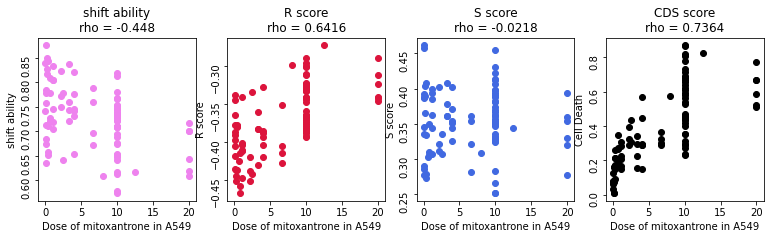

In [103]:
ShcorDoDrug(cell_line='A549', 
            drug_name='mitoxantrone',
            cds_result=cds_merged,
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

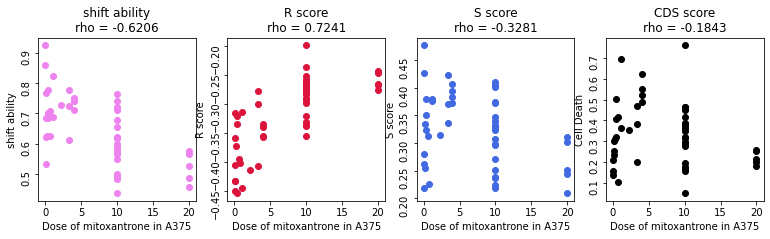

In [104]:
ShcorDoDrug(cell_line='A375', 
            drug_name='mitoxantrone',
            cds_result=cds_merged,
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

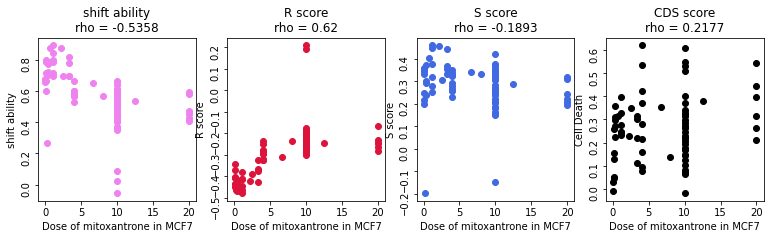

In [105]:
ShcorDoDrug(cell_line='MCF7', 
            drug_name='mitoxantrone',
            cds_result=cds_merged,
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

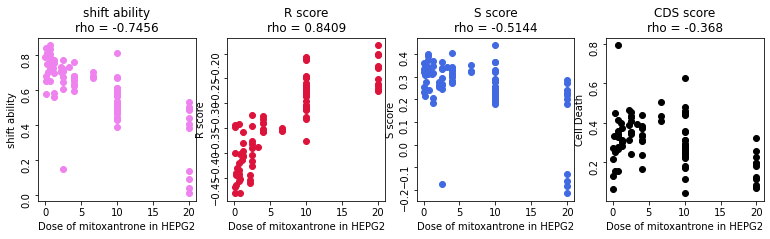

In [106]:
ShcorDoDrug(cell_line='HEPG2', 
            drug_name='mitoxantrone',
            cds_result=cds_merged,
            shift_result=all_cp_shift,
            corr_result=dosage_corr)

In [107]:
cds_corr = df(columns=['cell_line', 'cmap_name', 'moa', 'sample_number',
                        'dosage_number', 'shift_high', 'shift_low',
                        'corr_cds', 'p_cds'])
for d in all_cp_shift['cmap_name'].unique():
    tmp_d = all_cp_shift[all_cp_shift['cmap_name'] == d]

    
    for cl in tmp_d['cell_line'].unique():
        tmp_d_cl = tmp_d[tmp_d['cell_line'] == cl]
        if d in compound_info.index:
            cds_corr.at[cl + '|' + d, 'moa'] = compound_info.loc[d, 'moa']
        
        # only use 24h
        tmp_d_cl = tmp_d_cl[tmp_d_cl['pert_time'] == 24.]
        
        cds_corr.at[cl + '|' + d, 'cell_line'] = cl
        cds_corr.at[cl + '|' + d, 'cmap_name'] = d
        cds_corr.at[cl + '|' + d, 'sample_number'] = tmp_d_cl.shape[0]
        cds_corr.at[cl + '|' + d, 'dosage_number'] = tmp_d_cl['nearest_dose'].unique().shape[0]
        cds_corr.at[cl + '|' + d, 'shift_high'] = tmp_d_cl['shift_ability'].max()
        cds_corr.at[cl + '|' + d, 'shift_low'] = tmp_d_cl['shift_ability'].min()
        
        # correlation with only sample size > 5 and dosage number > 3
        if cds_corr.loc[cl + '|' + d, 'sample_number'] >= 5 and cds_corr.at[cl + '|' + d, 'dosage_number'] >= 3:
            tmp_cds = cds_merged[cds_merged.index.isin(tmp_d_cl.index)]
            c_sh, p_sh = stats.pearsonr(tmp_cds['cell_death_ave'], tmp_cds['nearest_dose'])

            cds_corr.at[cl + '|' + d, 'corr_cds'] = c_sh
            cds_corr.at[cl + '|' + d, 'p_cds'] = p_sh


In [108]:
cds_corr.to_csv(result_home + 'cds_corr_dosage.csv', sep=',')

In [109]:
cds_corr_cleaned = cds_corr.dropna(axis=0, how='any')
dosage_corr_cleaned = dosage_corr.dropna(axis=0, how='any')

In [110]:
dosage_corr_cleaned

cell_line     cmap_name                               moa  \
SKBR3|afatinib         SKBR3      afatinib                    EGFR inhibitor   
HEPG2|afatinib         HEPG2      afatinib                    EGFR inhibitor   
HCC515|afatinib       HCC515      afatinib                    EGFR inhibitor   
A375|afatinib           A375      afatinib                    EGFR inhibitor   
MDAMB231|dasatinib  MDAMB231     dasatinib                     KIT inhibitor   
...                      ...           ...                               ...   
HELA|gestrinone         HELA    gestrinone  Progesterone receptor antagonist   
A375|CEP-32496          A375     CEP-32496                     RAF inhibitor   
VCAP|troglitazone       VCAP  troglitazone                Insulin sensitizer   
PC3|troglitazone         PC3  troglitazone                Insulin sensitizer   
A375|indirubin          A375     indirubin                     CDK inhibitor   

                    sample_number  dosage_number  shift_high  shift_low  \
SKBR3|afatinib                  8              6    0.690177   0.087955   
HEPG2|afatinib                  5              3    0.582881  -0.411097   
HCC515|afatinib                 6              5    0.914562   0.568222   
A375|afatinib                   8              4    0.654979   0.096801   
MDAMB231|dasatinib             26             11    0.953159   0.652212   
...                           ...            ...         ...        ...   
HELA|gestrinone                 6              6   -0.580896  -0.844315   
A375|CEP-32496                  5              5    0.885055   0.577883   
VCAP|troglitazone               5              3    0.676555   0.531101   
PC3|troglitazone               17              6    0.560230  -0.609849   
A375|indirubin                  7              6    0.684814   0.477923   

                    corr_shift   p_shift    corr_R       p_R    corr_S  \
SKBR3|afatinib       -0.592283  0.121852  0.128418  0.761851 -0.622500   
HEPG2|afatinib       -0.418340  0.483325  0.429907  0.469988 -0.339338   
HCC515|afatinib      -0.400814  0.430975  0.389178  0.445705 -0.400557   
A375|afatinib         0.180488  0.668863 -0.904711  0.002011 -0.097932   
MDAMB231|dasatinib   -0.136496  0.506120 -0.021739  0.916053 -0.190770   
...                        ...       ...       ...       ...       ...   
HELA|gestrinone       0.189538  0.719097 -0.421290  0.405451  0.082895   
A375|CEP-32496       -0.961166  0.009133  0.387672  0.519060 -0.845369   
VCAP|troglitazone    -0.008549  0.989115  0.686683  0.200339  0.222143   
PC3|troglitazone      0.193378  0.457088 -0.048190  0.854276  0.272305   
A375|indirubin       -0.088597  0.850182  0.046452  0.921225 -0.118083   

                         p_S  
SKBR3|afatinib      0.099287  
HEPG2|afatinib      0.576383  
HCC515|afatinib     0.431299  
A375|afatinib       0.817548  
MDAMB231|dasatinib  0.350556  
...                      ...  
HELA|gestrinone     0.875942  
A375|CEP-32496      0.071275  
VCAP|troglitazone   0.719503  
PC3|troglitazone    0.290343  
A375|indirubin      0.800931  

[879 rows x 13 columns]

In [111]:
cds_corr_cleaned

cell_line     cmap_name                               moa  \
SKBR3|afatinib         SKBR3      afatinib                    EGFR inhibitor   
HEPG2|afatinib         HEPG2      afatinib                    EGFR inhibitor   
HCC515|afatinib       HCC515      afatinib                    EGFR inhibitor   
A375|afatinib           A375      afatinib                    EGFR inhibitor   
MDAMB231|dasatinib  MDAMB231     dasatinib                     KIT inhibitor   
...                      ...           ...                               ...   
HELA|gestrinone         HELA    gestrinone  Progesterone receptor antagonist   
A375|CEP-32496          A375     CEP-32496                     RAF inhibitor   
VCAP|troglitazone       VCAP  troglitazone                Insulin sensitizer   
PC3|troglitazone         PC3  troglitazone                Insulin sensitizer   
A375|indirubin          A375     indirubin                     CDK inhibitor   

                   sample_number dosage_number shift_high  shift_low  \
SKBR3|afatinib                 8             6   0.690177  0.0879546   
HEPG2|afatinib                 5             3   0.582881  -0.411097   
HCC515|afatinib                6             5   0.914562   0.568222   
A375|afatinib                  8             4   0.654979  0.0968009   
MDAMB231|dasatinib            26            11   0.953159   0.652212   
...                          ...           ...        ...        ...   
HELA|gestrinone                6             6  -0.580896  -0.844315   
A375|CEP-32496                 5             5   0.885055   0.577883   
VCAP|troglitazone              5             3   0.676555   0.531101   
PC3|troglitazone              17             6    0.56023  -0.609849   
A375|indirubin                 7             6   0.684814   0.477923   

                     corr_cds      p_cds  
SKBR3|afatinib      -0.281502   0.499405  
HEPG2|afatinib      -0.824462  0.0859237  
HCC515|afatinib      0.786065  0.0637564  
A375|afatinib        0.497076   0.210127  
MDAMB231|dasatinib   0.181695   0.374365  
...                       ...        ...  
HELA|gestrinone     -0.070953   0.893749  
A375|CEP-32496       0.634156    0.25054  
VCAP|troglitazone    0.323539   0.595361  
PC3|troglitazone    -0.327735   0.199078  
A375|indirubin     -0.0120203   0.979595  

[879 rows x 9 columns]

In [112]:
corr_merged = dosage_corr_cleaned.copy()
corr_merged['corr_cds'] = cds_corr_cleaned['corr_cds']
corr_merged['p_cds'] = cds_corr_cleaned['p_cds']

In [113]:
corr_merged.sort_values(by='p_shift', ascending=True)

cell_line         cmap_name                      moa  \
A549|MG-132               A549            MG-132     Proteasome inhibitor   
HEPG2|mitoxantrone       HEPG2      mitoxantrone  Topoisomerase inhibitor   
A549|withaferin-a         A549      withaferin-a            IKK inhibitor   
A549|daunorubicin         A549      daunorubicin  RNA synthesis inhibitor   
MCF7|mitoxantrone         MCF7      mitoxantrone  Topoisomerase inhibitor   
...                        ...               ...                      ...   
A549|PD-0325901           A549        PD-0325901            MEK inhibitor   
PC3|AZD-7762               PC3          AZD-7762            CHK inhibitor   
YAPC|colchicine           YAPC        colchicine    Microtubule inhibitor   
PC3|ingenol-mebutate       PC3  ingenol-mebutate            PKC activator   
A375|sunitinib            A375         sunitinib            KIT inhibitor   

                      sample_number  dosage_number  shift_high  shift_low  \
A549|MG-132                     549              4    0.546769  -0.767184   
HEPG2|mitoxantrone               88             16    0.858410   0.010586   
A549|withaferin-a                38              7    0.720672  -0.579096   
A549|daunorubicin                22              7    0.975334   0.596891   
MCF7|mitoxantrone                73             16    0.893477  -0.055578   
...                             ...            ...         ...        ...   
A549|PD-0325901                  40             10    0.939325   0.532177   
PC3|AZD-7762                     11              3    0.795261  -0.341459   
YAPC|colchicine                   7              7    0.583917  -0.011109   
PC3|ingenol-mebutate             11             11    0.772766   0.182485   
A375|sunitinib                    6              3    0.698089   0.530433   

                      corr_shift       p_shift    corr_R           p_R  \
A549|MG-132            -0.365245  9.079083e-19  0.433704  1.384421e-26   
HEPG2|mitoxantrone     -0.745569  7.941387e-17  0.840928  1.179544e-24   
A549|withaferin-a       0.764287  2.348942e-08 -0.452131  4.374655e-03   
A549|daunorubicin      -0.876670  8.748887e-08  0.806306  5.867874e-06   
MCF7|mitoxantrone      -0.535758  1.037487e-06  0.620037  4.923269e-09   
...                          ...           ...       ...           ...   
A549|PD-0325901         0.001305  9.936235e-01 -0.103326  5.257734e-01   
PC3|AZD-7762           -0.002577  9.940013e-01  0.059435  8.621919e-01   
YAPC|colchicine         0.003149  9.946539e-01 -0.472827  2.839365e-01   
PC3|ingenol-mebutate    0.001469  9.965808e-01  0.188720  5.783965e-01   
A375|sunitinib         -0.000880  9.986794e-01  0.112644  8.317492e-01   

                        corr_S           p_S   corr_cds        p_cds  
A549|MG-132          -0.041699  3.294437e-01  0.0224944      0.59894  
HEPG2|mitoxantrone   -0.514392  2.950350e-07     -0.368   0.00041962  
A549|withaferin-a     0.819322  3.195725e-10   0.574053  0.000164327  
A549|daunorubicin    -0.751732  5.491414e-05    0.79533  9.69586e-06  
MCF7|mitoxantrone    -0.189309  1.086960e-01   0.217698    0.0642895  
...                        ...           ...        ...          ...  
A549|PD-0325901      -0.056569  7.288123e-01   0.203486     0.207895  
PC3|AZD-7762          0.052154  8.789581e-01   0.373251     0.258205  
YAPC|colchicine      -0.069006  8.831300e-01   0.282612     0.539152  
PC3|ingenol-mebutate  0.034605  9.195453e-01  -0.402592     0.219605  
A375|sunitinib        0.182831  7.288091e-01 -0.0887219     0.867266  

[879 rows x 15 columns]

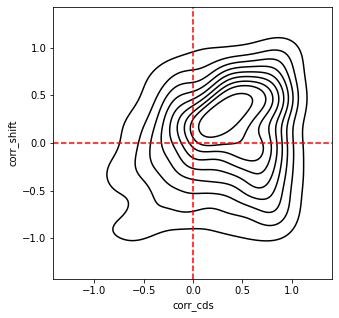

In [114]:
plt.figure(figsize=(5, 5))
sns.kdeplot(x='corr_cds', y='corr_shift', data=corr_merged, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

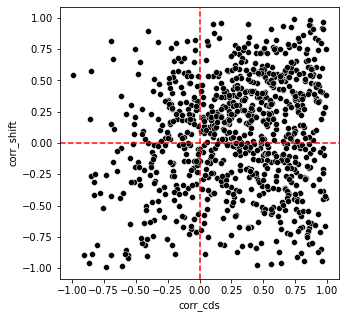

In [115]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_cds', y='corr_shift', data=corr_merged, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [116]:
stats.pearsonr(corr_merged['corr_cds'], corr_merged['corr_shift']) # positive correlation between CDS and shifting

(0.1557587340299299, 3.4891784535094845e-06)

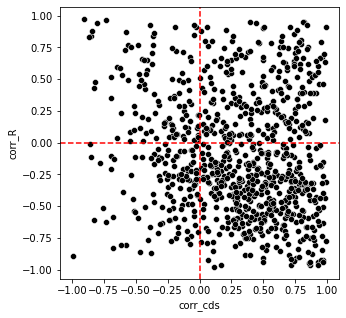

In [117]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_cds', y='corr_R', data=corr_merged, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [118]:
stats.pearsonr(corr_merged['corr_cds'], corr_merged['corr_R']) # negative correlation between CDS and R

(-0.12246908331159154, 0.0002731712703395639)

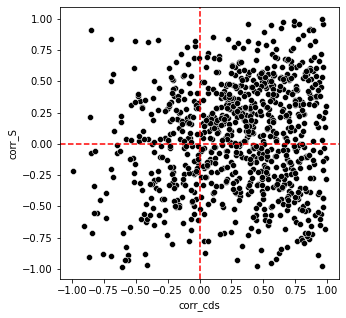

In [119]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_cds', y='corr_S', data=corr_merged, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [120]:
stats.pearsonr(corr_merged['corr_cds'], corr_merged['corr_S']) # positive correlation between CDS and S

(0.13339619875902983, 7.277202807596354e-05)

# 3. Apoptosis

In [129]:
tmp_apop = []
for ct in compound_cancer:
    tmp_lv5 = pd.read_csv(data_home + '/CMAP2020_Cancer/' + ct + '/CMAP2020_lv5_trt_cp_merged.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_lv5.index = tmp_lv5.index.astype(str)
    tmp_lv5 = tmp_lv5[tmp_lv5.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
    
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_cl = tmp_sig[tmp_sig['cell_mfc_name'] == cl].index
        tmp_cl_lv5 = tmp_lv5[tmp_cl]
        
        # get cell death
        tmp_cl_lv5 = df(tmp_cl_lv5[tmp_cl_lv5.index.isin(apop_bing)].mean(axis=0)).rename(columns={0: 'cell_death_ave'})
        tmp_cl_lv5['cell_line'] = cl
        tmp_cl_lv5['shift_ability'] = compound_result[ct]['shift_ability']
        tmp_apop.append(tmp_cl_lv5)

In [132]:
apop_merged = pd.concat(tmp_apop, axis=0)
apop_merged['nearest_dose'] = sig_info['nearest_dose']
apop_merged['pert_time'] = sig_info['pert_time']
apop_merged = apop_merged.rename(columns={'cell_death_ave': 'apoptosis_ave'})

In [133]:
apop_merged.to_csv(result_home + 'apoptosis_merged_41321_compound.csv', sep=',')

In [136]:
def ShcorDoDrug_apop(cell_line, drug_name, apop_result, shift_result, corr_result):
    '''
    Show correlation between dosage and shifting in specific cases
    '''
    tmp_shift = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_shift = tmp_shift[tmp_shift['cell_line'] == cell_line]
    tmp_shift = tmp_shift[tmp_shift['pert_time'] == 24.] # only show 24h
    tmp_apop = apop_result[apop_result.index.isin(tmp_shift.index)]
    
    # visualization
    f, axes = plt.subplots(1, 4, figsize=(13, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability',
                       data=tmp_shift, color='violet')
    plt.sca(axes[0])
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('shift ability')
    plt.title('shift ability\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_shift'], 4)))
    plt.yticks(rotation=90)
    
    im=axes[1].scatter(x='nearest_dose', y='R_score',
                       data=tmp_shift, color='crimson')
    plt.sca(axes[1])
    plt.title('R score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_R'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('R score')
    
    im=axes[2].scatter(x='nearest_dose', y='S_score',
                       data=tmp_shift, color='royalblue')
    plt.sca(axes[2])
    plt.title('S score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_S'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('S score')
    
    im=axes[3].scatter(x='nearest_dose', y='apoptosis_ave',
                       data=tmp_apop, color='k')
    apop_corr = stats.pearsonr(tmp_apop['apoptosis_ave'], tmp_apop['nearest_dose'])
    plt.sca(axes[3])
    plt.title('Apotosis \nrho = ' + np.str(np.round(apop_corr[0], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('Apoptosis')
    
    plt.show()
    
    return

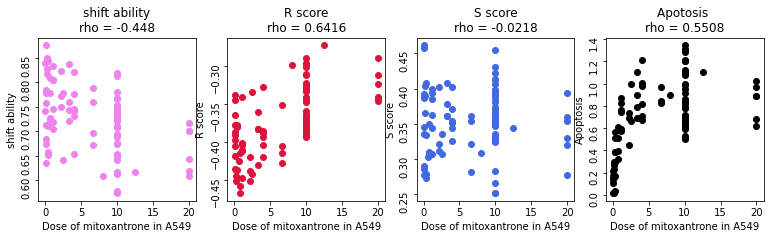

In [137]:
ShcorDoDrug_apop(cell_line='A549', 
                 drug_name='mitoxantrone',
                 apop_result=apop_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)

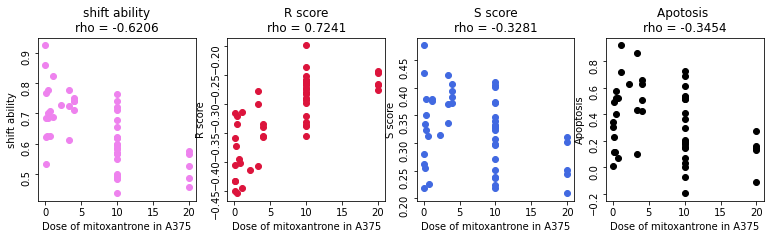

In [138]:
ShcorDoDrug_apop(cell_line='A375', 
                 drug_name='mitoxantrone',
                 apop_result=apop_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)

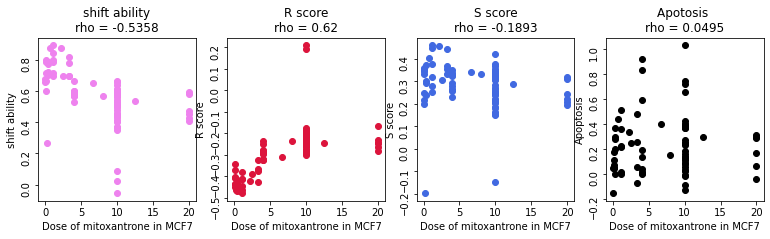

In [139]:
ShcorDoDrug_apop(cell_line='MCF7', 
                 drug_name='mitoxantrone',
                 apop_result=apop_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)

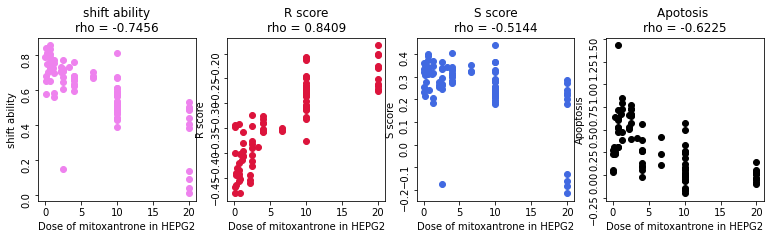

In [140]:
ShcorDoDrug_apop(cell_line='HEPG2', 
                 drug_name='mitoxantrone',
                 apop_result=apop_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)

# 4. Cell cycle

In [166]:
tmp_cellcycle = []
for ct in compound_cancer:
    tmp_lv5 = pd.read_csv(data_home + '/CMAP2020_Cancer/' + ct + '/CMAP2020_lv5_trt_cp_merged.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_lv5.index = tmp_lv5.index.astype(str)
    tmp_lv5 = tmp_lv5[tmp_lv5.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
    
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_cl = tmp_sig[tmp_sig['cell_mfc_name'] == cl].index
        tmp_cl_lv5 = tmp_lv5[tmp_cl]
        
        # get cell death
        tmp_cl_lv5 = df(tmp_cl_lv5[tmp_cl_lv5.index.isin(cellcycle_bing)].mean(axis=0)).rename(columns={0: 'cell_cycle_ave'})
        tmp_cl_lv5['cell_line'] = cl
        tmp_cl_lv5['shift_ability'] = compound_result[ct]['shift_ability']
        tmp_cellcycle.append(tmp_cl_lv5)

cellcycle_merged = pd.concat(tmp_cellcycle, axis=0)
cellcycle_merged['nearest_dose'] = sig_info['nearest_dose']
cellcycle_merged['pert_time'] = sig_info['pert_time']
cellcycle_merged

cellcycle_merged.to_csv(result_home + 'cellcycle_merged_41321_compound.csv', sep=',')

In [151]:
def ShcorDoDrug_cellcycle(cell_line, drug_name, cellcycle_result, shift_result, corr_result):
    '''
    Show correlation between dosage and shifting in specific cases
    '''
    tmp_shift = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_shift = tmp_shift[tmp_shift['cell_line'] == cell_line]
    tmp_shift = tmp_shift[tmp_shift['pert_time'] == 24.] # only show 24h
    tmp_cellcycle = cellcycle_result[cellcycle_result.index.isin(tmp_shift.index)]
    
    # visualization
    f, axes = plt.subplots(1, 4, figsize=(13, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability',
                       data=tmp_shift, color='violet')
    plt.sca(axes[0])
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('shift ability')
    plt.title('shift ability\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_shift'], 4)))
    plt.yticks(rotation=90)
    
    im=axes[1].scatter(x='nearest_dose', y='R_score',
                       data=tmp_shift, color='crimson')
    plt.sca(axes[1])
    plt.title('R score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_R'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('R score')
    
    im=axes[2].scatter(x='nearest_dose', y='S_score',
                       data=tmp_shift, color='royalblue')
    plt.sca(axes[2])
    plt.title('S score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_S'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('S score')
    
    im=axes[3].scatter(x='nearest_dose', y='cell_cycle_ave',
                       data=tmp_cellcycle, color='k')
    cellcycle_corr = stats.pearsonr(tmp_cellcycle['cell_cycle_ave'], tmp_cellcycle['nearest_dose'])
    plt.sca(axes[3])
    plt.title('Cell cycle \nrho = ' + np.str(np.round(cellcycle_corr[0], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('Cell cycle')
    
    plt.show()
    
    return

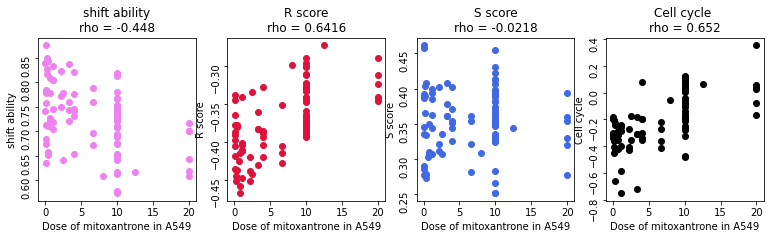

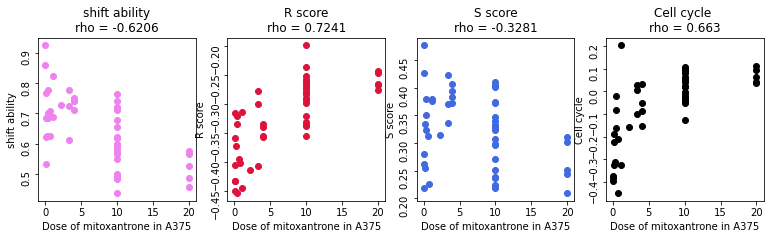

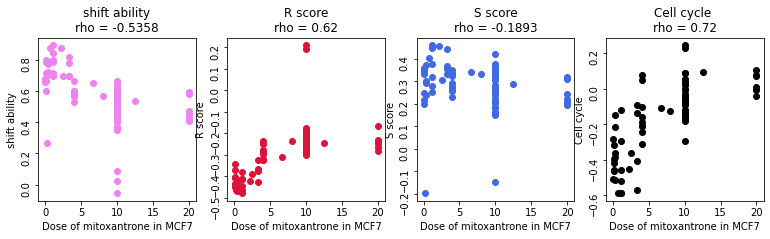

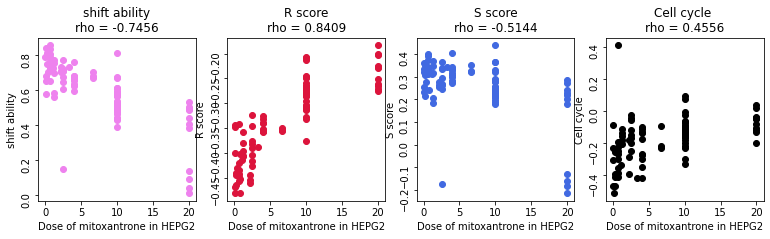

In [152]:
ShcorDoDrug_cellcycle(cell_line='A549', 
                 drug_name='mitoxantrone',
                 cellcycle_result=cellcycle_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)
ShcorDoDrug_cellcycle(cell_line='A375', 
                 drug_name='mitoxantrone',
                 cellcycle_result=cellcycle_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)
ShcorDoDrug_cellcycle(cell_line='MCF7', 
                 drug_name='mitoxantrone',
                 cellcycle_result=cellcycle_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)
ShcorDoDrug_cellcycle(cell_line='HEPG2', 
                 drug_name='mitoxantrone',
                 cellcycle_result=cellcycle_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)

# 5. Immune

In [159]:
tmp_immune = []
for ct in compound_cancer:
    tmp_lv5 = pd.read_csv(data_home + '/CMAP2020_Cancer/' + ct + '/CMAP2020_lv5_trt_cp_merged.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_lv5.index = tmp_lv5.index.astype(str)
    tmp_lv5 = tmp_lv5[tmp_lv5.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
    
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_cl = tmp_sig[tmp_sig['cell_mfc_name'] == cl].index
        tmp_cl_lv5 = tmp_lv5[tmp_cl]
        
        # get immune
        tmp_cl_lv5 = df(tmp_cl_lv5[tmp_cl_lv5.index.isin(immune_bing)].mean(axis=0)).rename(columns={0: 'immune_ave'})
        tmp_cl_lv5['cell_line'] = cl
        tmp_cl_lv5['shift_ability'] = compound_result[ct]['shift_ability']
        tmp_immune.append(tmp_cl_lv5)

immune_merged = pd.concat(tmp_immune, axis=0)
immune_merged['nearest_dose'] = sig_info['nearest_dose']
immune_merged['pert_time'] = sig_info['pert_time']
immune_merged

immune_merged.to_csv(result_home + 'immune_merged_41321_compound.csv', sep=',')

In [161]:
def ShcorDoDrug_immune(cell_line, drug_name, immune_result, shift_result, corr_result):
    '''
    Show correlation between dosage and shifting in specific cases
    '''
    tmp_shift = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_shift = tmp_shift[tmp_shift['cell_line'] == cell_line]
    tmp_shift = tmp_shift[tmp_shift['pert_time'] == 24.] # only show 24h
    tmp_immune = immune_result[immune_result.index.isin(tmp_shift.index)]
    
    # visualization
    f, axes = plt.subplots(1, 4, figsize=(13, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability',
                       data=tmp_shift, color='violet')
    plt.sca(axes[0])
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('shift ability')
    plt.title('shift ability\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_shift'], 4)))
    plt.yticks(rotation=90)
    
    im=axes[1].scatter(x='nearest_dose', y='R_score',
                       data=tmp_shift, color='crimson')
    plt.sca(axes[1])
    plt.title('R score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_R'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('R score')
    
    im=axes[2].scatter(x='nearest_dose', y='S_score',
                       data=tmp_shift, color='royalblue')
    plt.sca(axes[2])
    plt.title('S score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_S'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('S score')
    
    im=axes[3].scatter(x='nearest_dose', y='immune_ave',
                       data=tmp_immune, color='k')
    immune_corr = stats.pearsonr(tmp_immune['immune_ave'], tmp_immune['nearest_dose'])
    plt.sca(axes[3])
    plt.title('Immune \nrho = ' + np.str(np.round(immune_corr[0], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('Immune')
    
    plt.show()
    
    return

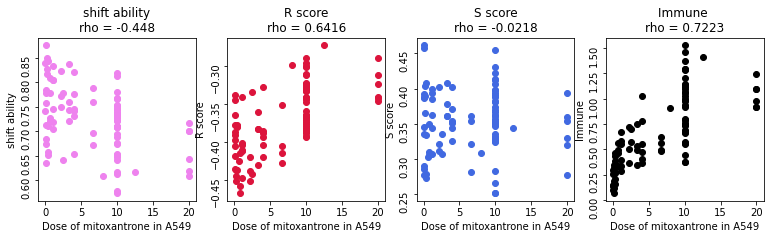

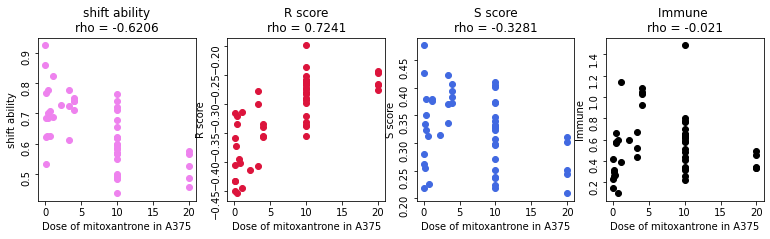

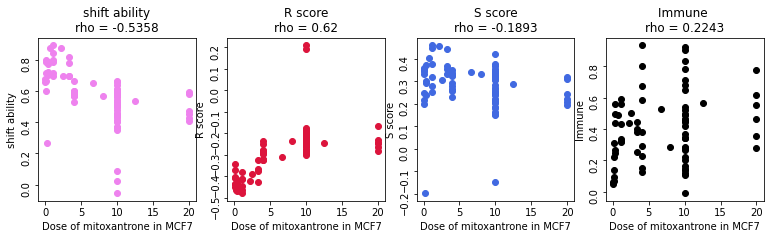

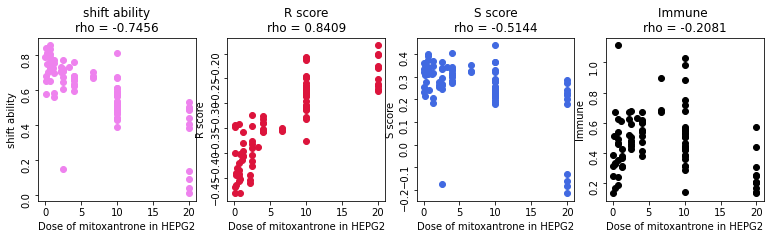

In [162]:
ShcorDoDrug_immune(cell_line='A549', 
                 drug_name='mitoxantrone',
                 immune_result=immune_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)
ShcorDoDrug_immune(cell_line='A375', 
                 drug_name='mitoxantrone',
                 immune_result=immune_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)
ShcorDoDrug_immune(cell_line='MCF7', 
                 drug_name='mitoxantrone',
                 immune_result=immune_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)
ShcorDoDrug_immune(cell_line='HEPG2', 
                 drug_name='mitoxantrone',
                 immune_result=immune_merged,
                 shift_result=all_cp_shift,
                 corr_result=dosage_corr)

<AxesSubplot:xlabel='cell_cycle_ave', ylabel='cell_death_ave'>

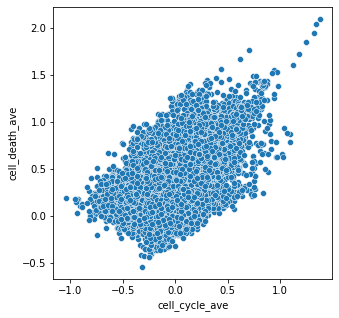

In [168]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=cellcycle_merged['cell_cycle_ave'], y=cds_merged['cell_death_ave'])

<AxesSubplot:xlabel='immune_ave', ylabel='cell_death_ave'>

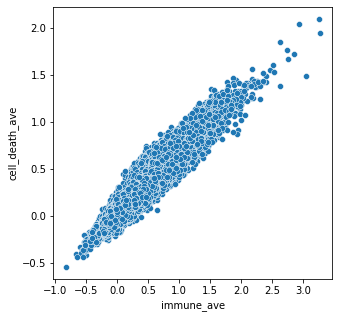

In [169]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=immune_merged['immune_ave'], y=cds_merged['cell_death_ave'])

<AxesSubplot:xlabel='immune_ave', ylabel='cell_cycle_ave'>

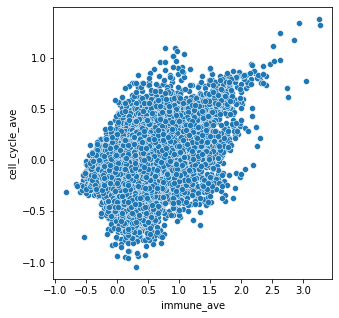

In [171]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=immune_merged['immune_ave'], y=cellcycle_merged['cell_cycle_ave'])

# GSEA

In [275]:
# write to new .gmt
merged_set = {'cell_death': gobp_bing,
              'apoptosis': apop_bing,
              'cell_cycle': cellcycle_bing,
              'immune': immune_bing}
with open(gsea_home + 'gene_sets/GOBP_death_cycle_immune_merged.gmt', 'w') as f:
    for k in merged_set.keys():
        f.write(k + '\t' + '\t'.join(merged_set[k]) + '\n')

In [173]:
for ct in compound_cancer:
    tmp_lv5 = pd.read_csv(data_home + '/CMAP2020_Cancer/' + ct + '/CMAP2020_lv5_trt_cp_merged.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_lv5.index = tmp_lv5.index.astype(str)
    tmp_lv5 = tmp_lv5[tmp_lv5.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])
    
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_cl = tmp_sig[tmp_sig['cell_mfc_name'] == cl].index
        tmp_cl_lv5 = tmp_lv5[tmp_cl]
        
        tmp_nes = df(columns=tmp_cl_lv5.columns)
        tmp_fdr = df(columns=tmp_cl_lv5.columns)
        for c in tmp_cl_lv5.columns:
            tmp_result = gp.prerank(df(tmp_cl_lv5[c]).sort_values(by=c, ascending=False),
                                    gene_sets=gsea_home + 'gene_sets/GOBP_death_cycle_immune_merged.gmt',
                                    processes=20,
                                    permutation_num=100,
                                    outdir=None, seed=0, min_size=10, max_size=2000)
            tmp_nes[c] = tmp_result.res2d['nes']
            tmp_fdr[c] = tmp_result.res2d['fdr']
            
        tmp_nes.to_csv(result_home + 'GSEA_GO/' + cl + '_GO_death_cycle_immune_NES.csv', sep=',')
        tmp_fdr.to_csv(result_home + 'GSEA_GO/' + cl + '_GO_death_cycle_immune_FDR.csv', sep=',')

In [176]:
# read results
tmp_ls = os.listdir(result_home + 'GSEA_GO/')
tmp_nes_list = []
tmp_fdr_list = []

for c in tmp_ls:
    if c.split('_')[-1] == 'NES.csv':
        tmp_nes_list.append(pd.read_csv(result_home + 'GSEA_GO/' + c,
                                        header=0, index_col=0, sep=',').T)
    elif c.split('_')[-1] == 'FDR.csv':
        tmp_fdr_list.append(pd.read_csv(result_home + 'GSEA_GO/' + c,
                                        header=0, index_col=0, sep=',').T)

In [188]:
nes_merged = pd.concat(tmp_nes_list, axis=0)
nes_merged['cell_line'] = sig_info['cell_mfc_name']
nes_merged['nearest_dose'] = sig_info['nearest_dose']
fdr_merged = pd.concat(tmp_fdr_list, axis=0)
fdr_merged['cell_line'] = sig_info['cell_mfc_name']
fdr_merged['nearest_dose'] = sig_info['nearest_dose']

In [189]:
nes_merged

cell_cycle    immune  cell_death  \
DTAK001_DU145_24H:BRD-K51544265:20          -1.884451  1.583319    1.316173   
ERBB2001_DV90_24H:BRD-K42805893:1                 inf  0.888042    0.628202   
ERBB2001_DV90_24H:BRD-K42805893:10          -2.097153  1.118637    1.032585   
CPC006_DV90_6H:BRD-A67788537-001-01-7:120         inf  1.270227    1.082127   
CPC006_DV90_6H:BRD-K35960502-001-10-1:10     0.874896  1.230403    1.004302   
...                                               ...       ...         ...   
LJP006_LNCAP_24H:J19                        -1.932375  1.111347    0.925871   
LJP006_LNCAP_24H:N05                        -1.570033  1.085407    1.151643   
LJP006_LNCAP_24H:A08                        -1.172332  0.752109    1.048805   
LJP006_LNCAP_3H:H16                               inf  1.173146    0.833620   
LJP006_LNCAP_3H:G14                         -1.261271  1.379471    1.339949   

                                           apoptosis cell_line  nearest_dose  
DTAK001_DU145_24H:BRD-K51544265:20          0.671405     DU145         20.00  
ERBB2001_DV90_24H:BRD-K42805893:1           0.680746      DV90          1.11  
ERBB2001_DV90_24H:BRD-K42805893:10          0.880956      DV90         10.00  
CPC006_DV90_6H:BRD-A67788537-001-01-7:120  -1.145093      DV90        125.00  
CPC006_DV90_6H:BRD-K35960502-001-10-1:10    1.030556      DV90         10.00  
...                                              ...       ...           ...  
LJP006_LNCAP_24H:J19                       -1.051841     LNCAP         10.00  
LJP006_LNCAP_24H:N05                        0.968690     LNCAP          0.12  
LJP006_LNCAP_24H:A08                        1.162918     LNCAP          3.33  
LJP006_LNCAP_3H:H16                         0.773678     LNCAP          0.37  
LJP006_LNCAP_3H:G14                        -1.266488     LNCAP          3.33  

[41321 rows x 6 columns]

<AxesSubplot:xlabel='immune', ylabel='cell_cycle'>

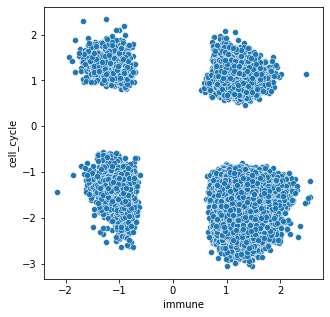

In [181]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=nes_merged['immune'], y=nes_merged['cell_cycle'])

<AxesSubplot:xlabel='immune', ylabel='apoptosis'>

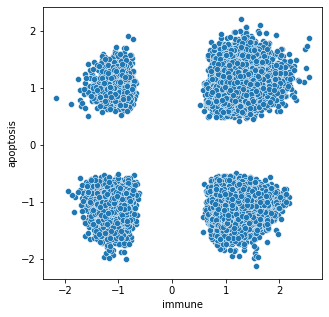

In [182]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=nes_merged['immune'], y=nes_merged['apoptosis'])

<AxesSubplot:xlabel='immune', ylabel='cell_death'>

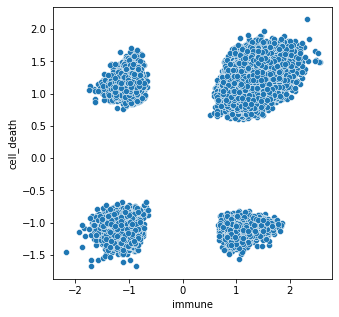

In [183]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=nes_merged['immune'], y=nes_merged['cell_death'])

<AxesSubplot:xlabel='apoptosis', ylabel='cell_death'>

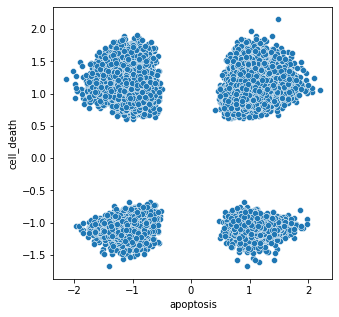

In [184]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=nes_merged['apoptosis'], y=nes_merged['cell_death'])

In [209]:
def ShcorDoDrug_go(cell_line, drug_name, go_term, go_result, shift_result, corr_result):
    '''
    Show correlation between dosage and shifting in specific cases
    '''
    tmp_shift = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_shift = tmp_shift[tmp_shift['cell_line'] == cell_line]
    tmp_shift = tmp_shift[tmp_shift['pert_time'] == 24.] # only show 24h
    tmp_go = go_result[go_result.index.isin(tmp_shift.index)]
    
    # visualization
    f, axes = plt.subplots(1, 4, figsize=(13, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability',
                       data=tmp_shift, color='violet')
    plt.sca(axes[0])
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('shift ability')
    plt.title('shift ability\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_shift'], 4)))
    plt.yticks(rotation=90)
    
    im=axes[1].scatter(x='nearest_dose', y='R_score',
                       data=tmp_shift, color='crimson')
    plt.sca(axes[1])
    plt.title('R score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_R'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('R score')
    
    im=axes[2].scatter(x='nearest_dose', y='S_score',
                       data=tmp_shift, color='royalblue')
    plt.sca(axes[2])
    plt.title('S score\nrho = ' + np.str(np.round(corr_result.loc[cell_line + '|' + drug_name, 'corr_S'], 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel('S score')
    
    im=axes[3].scatter(x='nearest_dose', y=go_term,
                       data=tmp_go, color='k')
    
    # drop inf
    tmp_go_inf = tmp_go.copy()
    tmp_go_inf.replace([-np.inf, np.inf], np.nan, inplace=True)
    tmp_go_inf = tmp_go_inf.dropna(axis=0, how='any')
    go_corr = stats.pearsonr(tmp_go_inf[go_term], tmp_go_inf['nearest_dose'])[0]

    plt.sca(axes[3])
    plt.title(go_term + '\nrho = ' + np.str(np.round(go_corr, 4)))
    plt.yticks(rotation=90)
    plt.xlabel('Dose of ' + drug_name + ' in ' + cell_line)
    plt.ylabel(go_term)
    
    plt.show()
    
    return

In [191]:
nes_merged

cell_cycle    immune  cell_death  \
DTAK001_DU145_24H:BRD-K51544265:20          -1.884451  1.583319    1.316173   
ERBB2001_DV90_24H:BRD-K42805893:1                 inf  0.888042    0.628202   
ERBB2001_DV90_24H:BRD-K42805893:10          -2.097153  1.118637    1.032585   
CPC006_DV90_6H:BRD-A67788537-001-01-7:120         inf  1.270227    1.082127   
CPC006_DV90_6H:BRD-K35960502-001-10-1:10     0.874896  1.230403    1.004302   
...                                               ...       ...         ...   
LJP006_LNCAP_24H:J19                        -1.932375  1.111347    0.925871   
LJP006_LNCAP_24H:N05                        -1.570033  1.085407    1.151643   
LJP006_LNCAP_24H:A08                        -1.172332  0.752109    1.048805   
LJP006_LNCAP_3H:H16                               inf  1.173146    0.833620   
LJP006_LNCAP_3H:G14                         -1.261271  1.379471    1.339949   

                                           apoptosis cell_line  nearest_dose  
DTAK001_DU145_24H:BRD-K51544265:20          0.671405     DU145         20.00  
ERBB2001_DV90_24H:BRD-K42805893:1           0.680746      DV90          1.11  
ERBB2001_DV90_24H:BRD-K42805893:10          0.880956      DV90         10.00  
CPC006_DV90_6H:BRD-A67788537-001-01-7:120  -1.145093      DV90        125.00  
CPC006_DV90_6H:BRD-K35960502-001-10-1:10    1.030556      DV90         10.00  
...                                              ...       ...           ...  
LJP006_LNCAP_24H:J19                       -1.051841     LNCAP         10.00  
LJP006_LNCAP_24H:N05                        0.968690     LNCAP          0.12  
LJP006_LNCAP_24H:A08                        1.162918     LNCAP          3.33  
LJP006_LNCAP_3H:H16                         0.773678     LNCAP          0.37  
LJP006_LNCAP_3H:G14                        -1.266488     LNCAP          3.33  

[41321 rows x 6 columns]

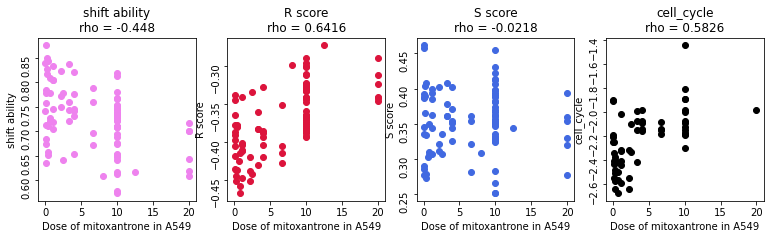

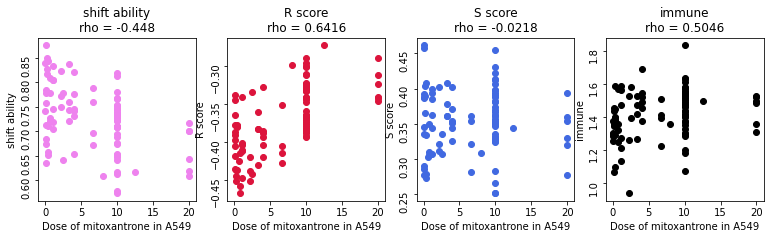

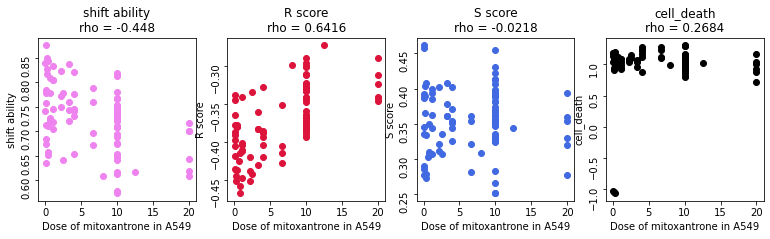

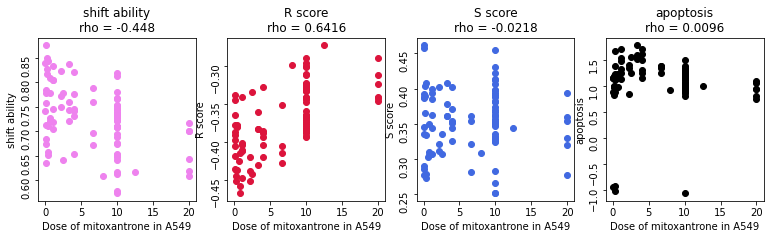

In [210]:
ShcorDoDrug_go(cell_line='A549', 
               drug_name='mitoxantrone',
               go_term='cell_cycle',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)
ShcorDoDrug_go(cell_line='A549', 
               drug_name='mitoxantrone',
               go_term='immune',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)
ShcorDoDrug_go(cell_line='A549', 
               drug_name='mitoxantrone',
               go_term='cell_death',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)
ShcorDoDrug_go(cell_line='A549', 
               drug_name='mitoxantrone',
               go_term='apoptosis',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)

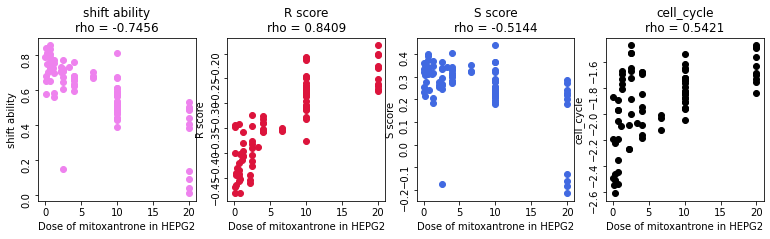

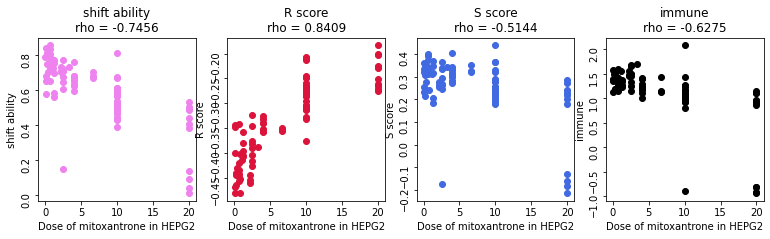

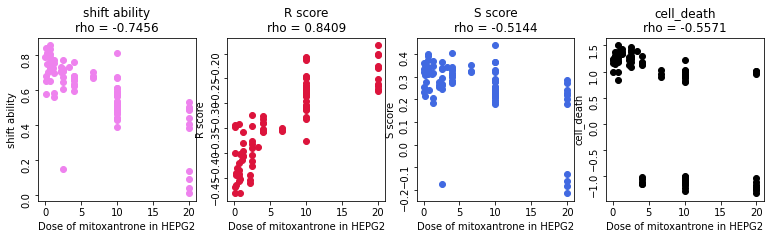

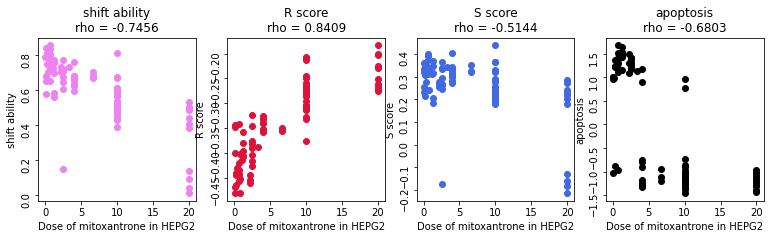

In [211]:
ShcorDoDrug_go(cell_line='HEPG2', 
               drug_name='mitoxantrone',
               go_term='cell_cycle',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)
ShcorDoDrug_go(cell_line='HEPG2', 
               drug_name='mitoxantrone',
               go_term='immune',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)
ShcorDoDrug_go(cell_line='HEPG2', 
               drug_name='mitoxantrone',
               go_term='cell_death',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)
ShcorDoDrug_go(cell_line='HEPG2', 
               drug_name='mitoxantrone',
               go_term='apoptosis',  
               go_result=nes_merged,
               shift_result=all_cp_shift,
               corr_result=dosage_corr)

In [243]:
nes_all_corr = df(columns=['cell_line', 'cmap_name', 'moa', 'sample_number',
                        'dosage_number', 'shift_high', 'shift_low'])
for d in all_cp_shift['cmap_name'].unique():
    tmp_d = all_cp_shift[all_cp_shift['cmap_name'] == d]

    
    for cl in tmp_d['cell_line'].unique():
        tmp_d_cl = tmp_d[tmp_d['cell_line'] == cl]
        if d in compound_info.index:
            nes_all_corr.at[cl + '|' + d, 'moa'] = compound_info.loc[d, 'moa']
        
        # only use 24h
        tmp_d_cl = tmp_d_cl[tmp_d_cl['pert_time'] == 24.]
        
        nes_all_corr.at[cl + '|' + d, 'cell_line'] = cl
        nes_all_corr.at[cl + '|' + d, 'cmap_name'] = d
        nes_all_corr.at[cl + '|' + d, 'sample_number'] = tmp_d_cl.shape[0]
        nes_all_corr.at[cl + '|' + d, 'dosage_number'] = tmp_d_cl['nearest_dose'].unique().shape[0]
        nes_all_corr.at[cl + '|' + d, 'shift_high'] = tmp_d_cl['shift_ability'].max()
        nes_all_corr.at[cl + '|' + d, 'shift_low'] = tmp_d_cl['shift_ability'].min()
        
        # correlation with only sample size > 5 and dosage number > 3
        if nes_all_corr.loc[cl + '|' + d, 'sample_number'] >= 5 and nes_all_corr.at[cl + '|' + d, 'dosage_number'] >= 3:
            tmp_nes = nes_merged[nes_merged.index.isin(tmp_d_cl.index)]
            tmp_go_inf = tmp_nes.copy()
            tmp_go_inf.replace([-np.inf, np.inf], np.nan, inplace=True)
            
            for t in ['cell_cycle', 'immune', 'cell_death', 'apoptosis']:
                tmp_t = df(tmp_go_inf[[t, 'nearest_dose']]).dropna(axis=0, how='any')
                if tmp_t.shape[0] >= 5:
                    tmp_corr, tmp_p = stats.pearsonr(tmp_t[t], tmp_t['nearest_dose'])

                    nes_all_corr.at[cl + '|' + d, 'corr_' + t] = tmp_corr
                    nes_all_corr.at[cl + '|' + d, 'p_' + t] = tmp_p


In [244]:
nes_all_corr_cleaned = nes_all_corr.dropna(axis=0, how='any')
nes_all_corr_cleaned

cell_line     cmap_name                               moa  \
HCC515|afatinib       HCC515      afatinib                    EGFR inhibitor   
A375|afatinib           A375      afatinib                    EGFR inhibitor   
MDAMB231|dasatinib  MDAMB231     dasatinib                     KIT inhibitor   
HS578T|dasatinib      HS578T     dasatinib                     KIT inhibitor   
HT29|dasatinib          HT29     dasatinib                     KIT inhibitor   
...                      ...           ...                               ...   
HELA|gestrinone         HELA    gestrinone  Progesterone receptor antagonist   
A375|CEP-32496          A375     CEP-32496                     RAF inhibitor   
VCAP|troglitazone       VCAP  troglitazone                Insulin sensitizer   
PC3|troglitazone         PC3  troglitazone                Insulin sensitizer   
A375|indirubin          A375     indirubin                     CDK inhibitor   

                   sample_number dosage_number shift_high  shift_low  \
HCC515|afatinib                6             5   0.914562   0.568222   
A375|afatinib                  8             4   0.654979  0.0968009   
MDAMB231|dasatinib            26            11   0.953159   0.652212   
HS578T|dasatinib               7             4   0.707741   0.496869   
HT29|dasatinib                12             7   0.818703   0.467727   
...                          ...           ...        ...        ...   
HELA|gestrinone                6             6  -0.580896  -0.844315   
A375|CEP-32496                 5             5   0.885055   0.577883   
VCAP|troglitazone              5             3   0.676555   0.531101   
PC3|troglitazone              17             6    0.56023  -0.609849   
A375|indirubin                 7             6   0.684814   0.477923   

                    corr_immune  p_immune  corr_cell_death  p_cell_death  \
HCC515|afatinib        0.684296  0.133770         0.753148      0.083883   
A375|afatinib         -0.001242  0.997672        -0.200336      0.634299   
MDAMB231|dasatinib    -0.066806  0.745746        -0.371240      0.067686   
HS578T|dasatinib       0.612998  0.143286        -0.591988      0.292948   
HT29|dasatinib         0.323076  0.305693        -0.466602      0.126225   
...                         ...       ...              ...           ...   
HELA|gestrinone        0.128175  0.808791        -0.497597      0.315208   
A375|CEP-32496         0.111582  0.858225         0.396881      0.508274   
VCAP|troglitazone      0.413380  0.489068        -0.718160      0.171818   
PC3|troglitazone       0.153146  0.557324         0.099944      0.712670   
A375|indirubin        -0.390433  0.444109        -0.392321      0.384025   

                    corr_apoptosis  p_apoptosis  corr_cell_cycle  p_cell_cycle  
HCC515|afatinib           0.495787     0.317253         0.351469      0.561888  
A375|afatinib             0.223515     0.594658         0.299379      0.471304  
MDAMB231|dasatinib       -0.140530     0.493513        -0.098674      0.638886  
HS578T|dasatinib          0.045847     0.922249        -0.308259      0.613821  
HT29|dasatinib           -0.028116     0.930880        -0.665912      0.050221  
...                            ...          ...              ...           ...  
HELA|gestrinone          -0.438487     0.384424        -0.494625      0.318569  
A375|CEP-32496            0.065847     0.916221         0.473023      0.421010  
VCAP|troglitazone         0.401672     0.502681        -0.162515      0.793994  
PC3|troglitazone          0.107401     0.681595        -0.637494      0.007896  
A375|indirubin            0.142163     0.761088        -0.573989      0.177808  

[744 rows x 15 columns]

In [245]:
nes_all_corr_cleaned['corr_shift'] = dosage_corr['corr_shift']
nes_all_corr_cleaned['p_shift'] = dosage_corr['p_shift']
nes_all_corr_cleaned['corr_R'] = dosage_corr['corr_R']
nes_all_corr_cleaned['p_R'] = dosage_corr['p_R']
nes_all_corr_cleaned['corr_S'] = dosage_corr['corr_S']
nes_all_corr_cleaned['p_S'] = dosage_corr['p_S']

<ipython-input-245-6576a20e421e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nes_all_corr_cleaned['corr_shift'] = dosage_corr['corr_shift']
<ipython-input-245-6576a20e421e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nes_all_corr_cleaned['p_shift'] = dosage_corr['p_shift']
<ipython-input-245-6576a20e421e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [246]:
nes_all_corr_cleaned.to_csv(result_home + 'corr_dose_NES_GO_merged.csv', sep=',')

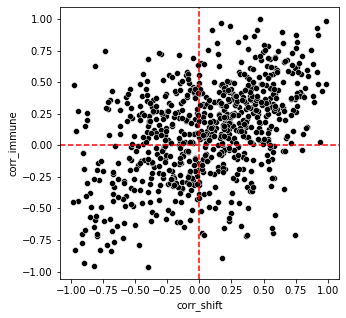

In [247]:
# asscoiation between dose-shift and dose-goterms
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_shift', y='corr_immune', data=nes_all_corr_cleaned, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [320]:
stats.pearsonr(nes_all_corr_cleaned['corr_shift'], nes_all_corr_cleaned['corr_immune'])

(0.4476611387783571, 6.012391643430452e-38)

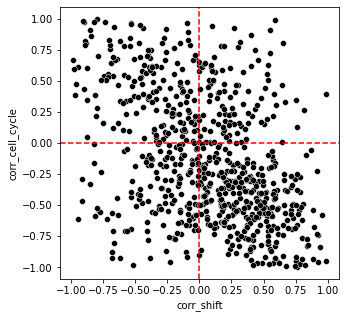

In [252]:
# asscoiation between dose-shift and dose-goterms
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_shift', y='corr_cell_cycle', data=nes_all_corr_cleaned, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [319]:
stats.pearsonr(nes_all_corr_cleaned['corr_shift'], nes_all_corr_cleaned['corr_cell_cycle'])

(-0.430319947824723, 6.840529539604478e-35)

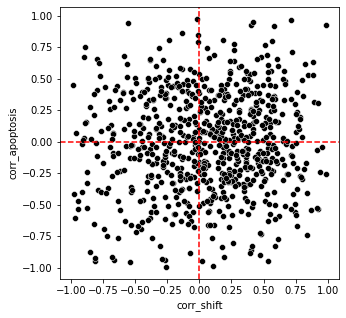

In [258]:
# asscoiation between dose-shift and dose-goterms
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_shift', y='corr_apoptosis', data=nes_all_corr_cleaned, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [328]:
stats.pearsonr(nes_all_corr_cleaned['corr_shift'], nes_all_corr_cleaned['corr_apoptosis'])

(0.057013301172488616, 0.12024055042703245)

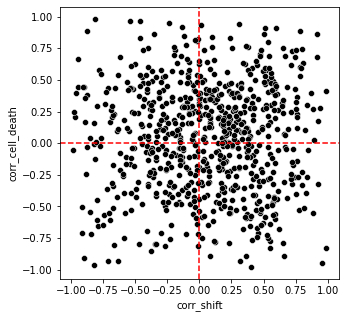

In [248]:
# asscoiation between dose-shift and dose-goterms
plt.figure(figsize=(5, 5))
sns.scatterplot(x='corr_shift', y='corr_cell_death', data=nes_all_corr_cleaned, color='k')
plt.axvline(x=0., ls='--', c='r')
plt.axhline(y=0., ls='--', c='r')

In [262]:
# cell cycle
neg_sh_neg_cc = nes_all_corr_cleaned[nes_all_corr_cleaned['corr_shift'] < 0]
neg_sh_neg_cc = neg_sh_neg_cc[neg_sh_neg_cc['corr_cell_cycle'] < 0]
neg_sh_neg_cc_neg_im = neg_sh_neg_cc[neg_sh_neg_cc['corr_immune'] < 0]
neg_sh_neg_cc_neg_im = neg_sh_neg_cc_neg_im.sort_values(by='p_shift', ascending=True)

In [268]:
neg_sh_neg_cc_neg_im.index[:20]

Index(['HT29|mitoxantrone', 'HT29|doxorubicin', 'A549|bortezomib',
       'HS578T|AZD-8055', 'PC3|PCI-24781', 'YAPC|PHA-848125',
       'A549|parbendazole', 'HT29|daunorubicin', 'YAPC|belinostat',
       'PC3|vorinostat', 'A375|ENMD-2076', 'HT29|camptothecin',
       'A549|cyclosporin-a', 'MCF7|parbendazole', 'MDAMB231|AZD-7762',
       'PC3|BIIB-021', 'HEPG2|selumetinib', 'PC3|daunorubicin', 'PC3|rotenone',
       'HT29|epirubicin'],
      dtype='object')

HT29|mitoxantrone


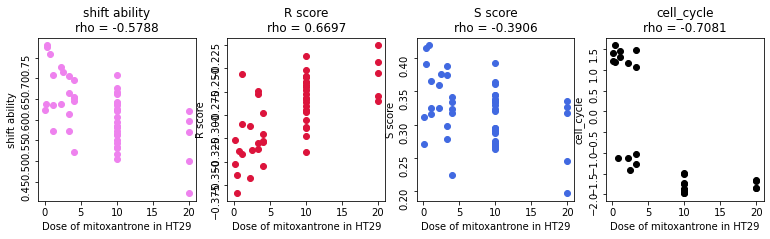

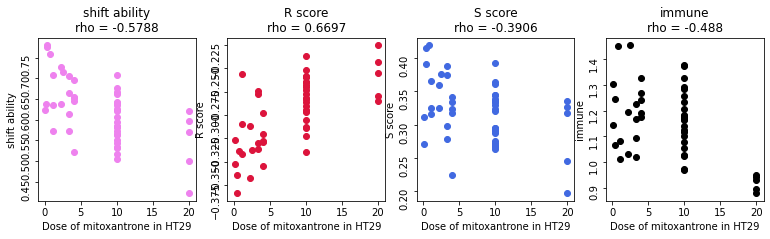



HT29|doxorubicin


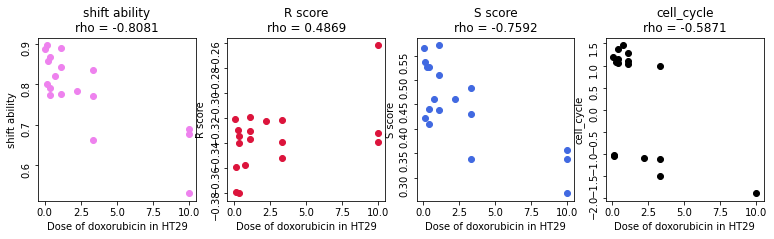

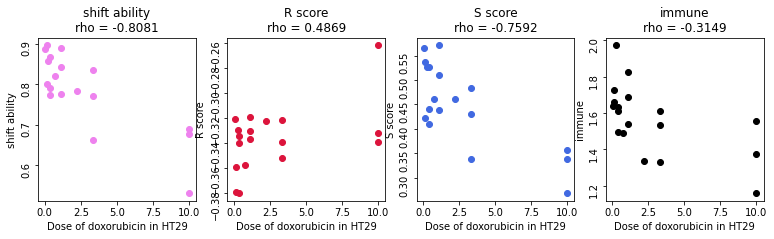



A549|bortezomib


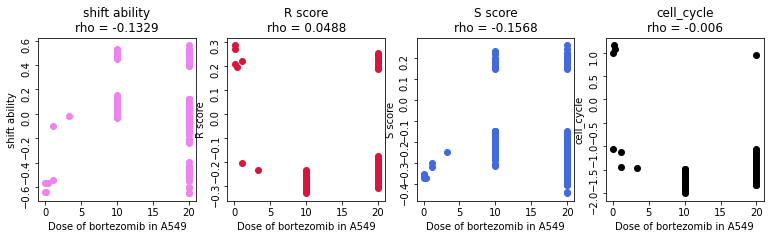

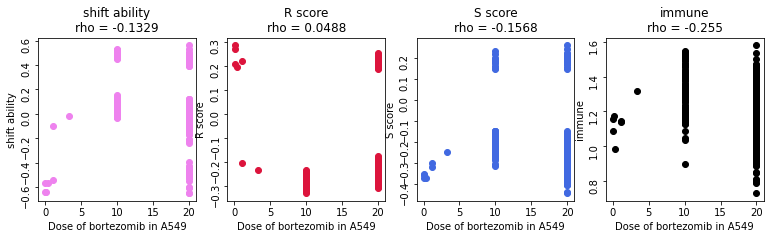



HS578T|AZD-8055


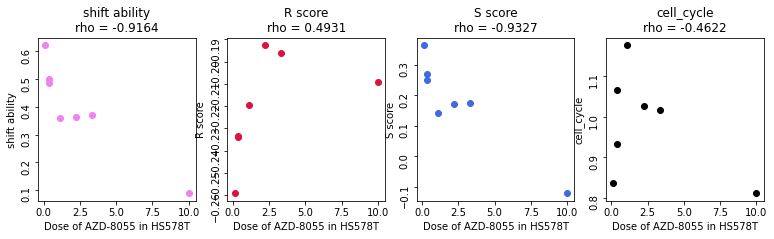

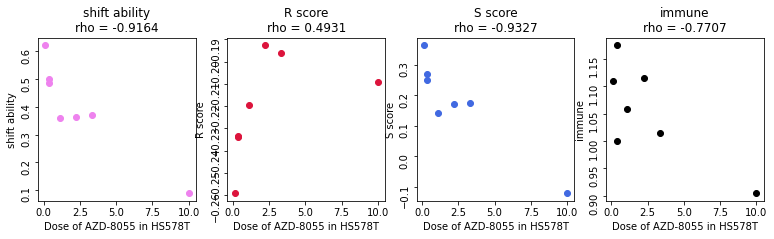



PC3|PCI-24781


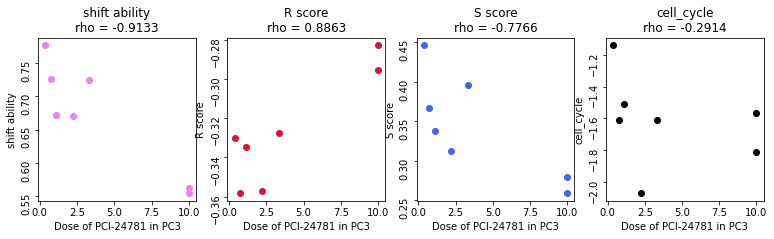

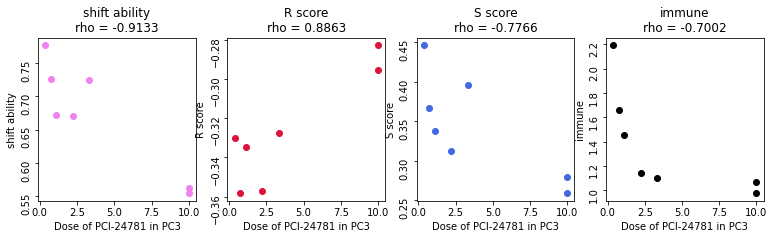



YAPC|PHA-848125


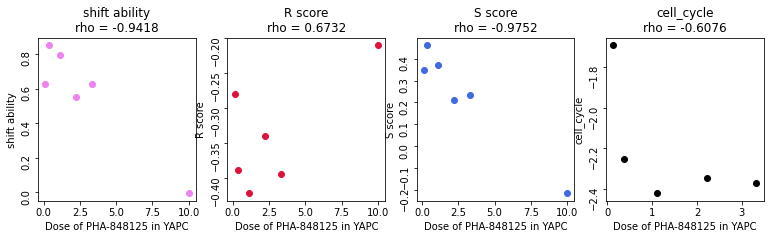

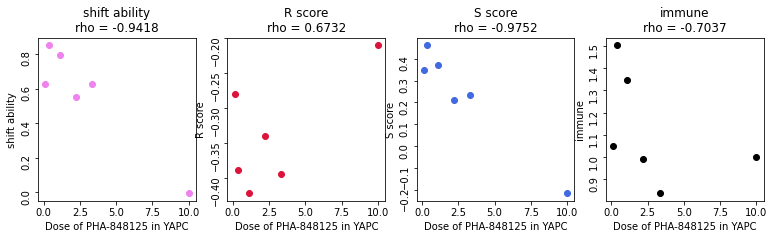



A549|parbendazole


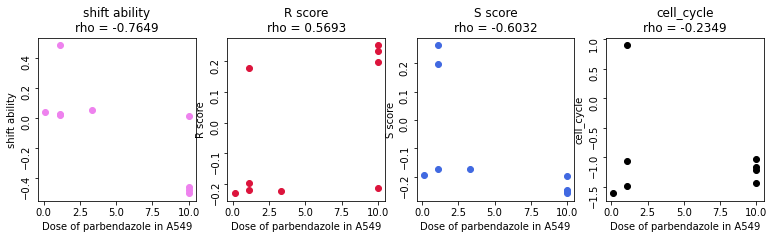

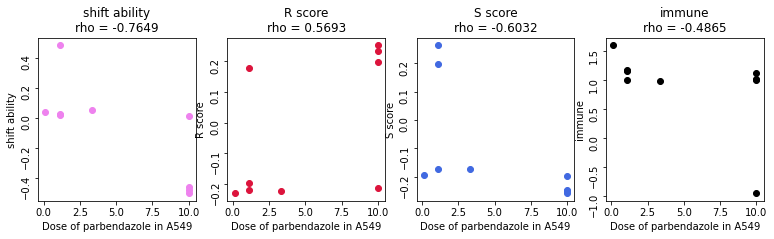



HT29|daunorubicin


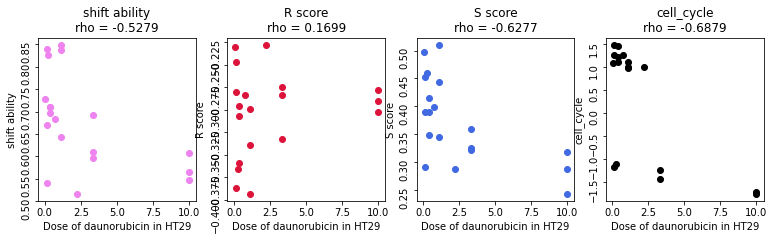

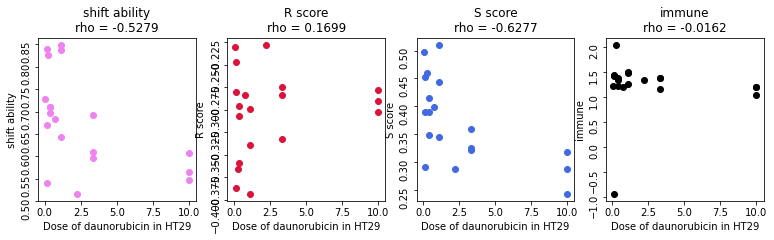



YAPC|belinostat


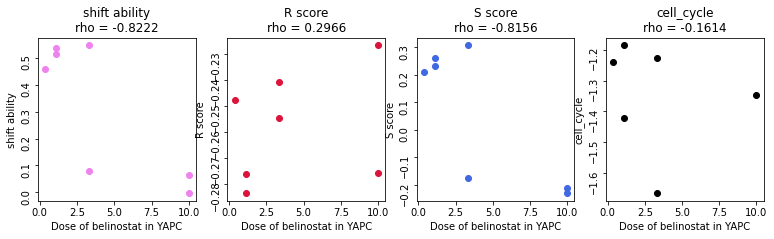

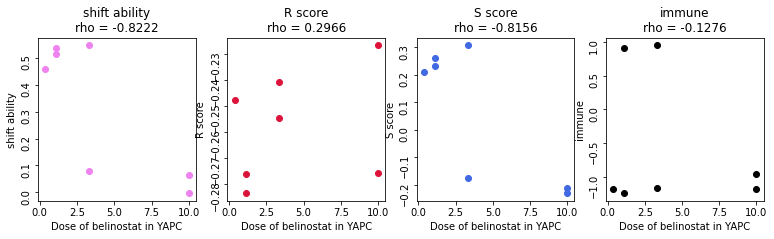



PC3|vorinostat


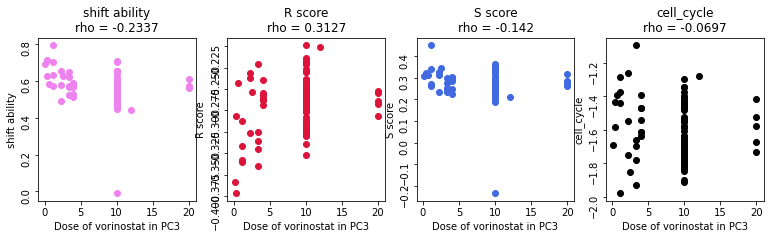

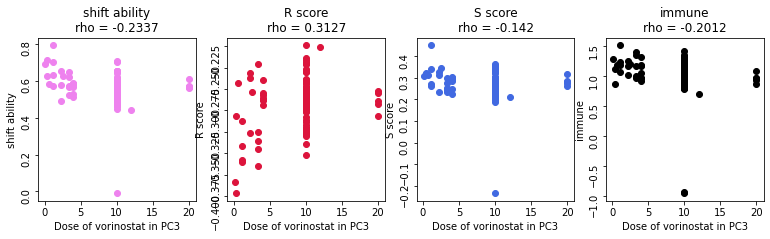



A375|ENMD-2076


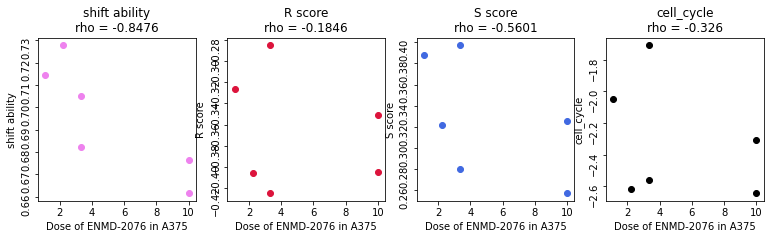

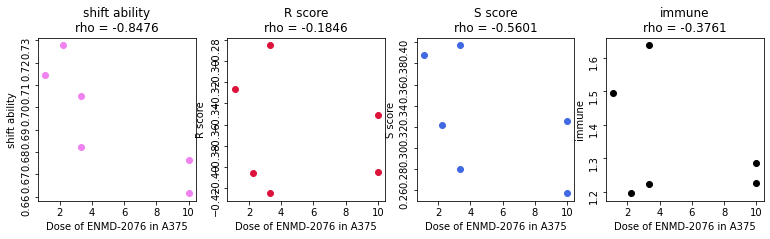



HT29|camptothecin


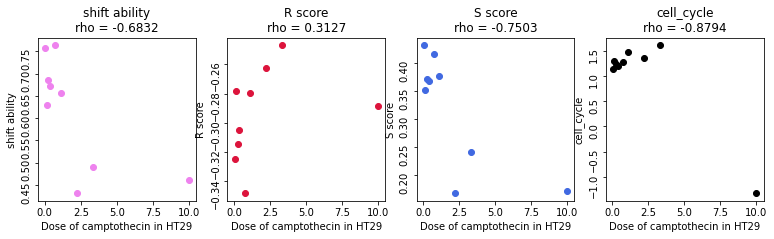

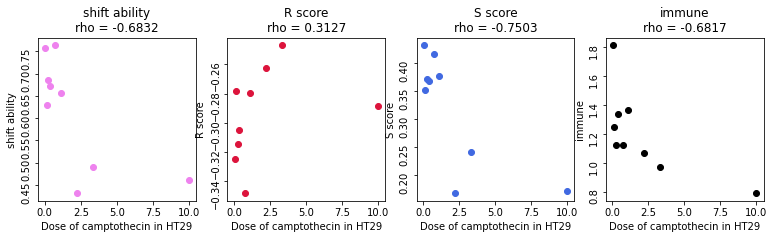



A549|cyclosporin-a


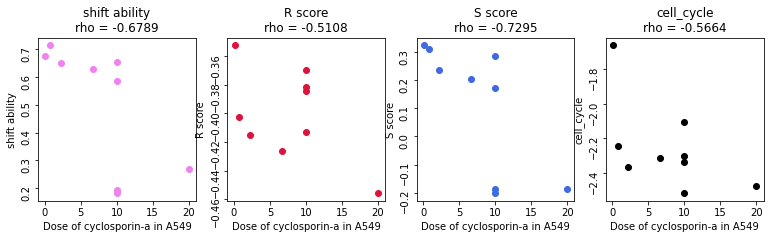

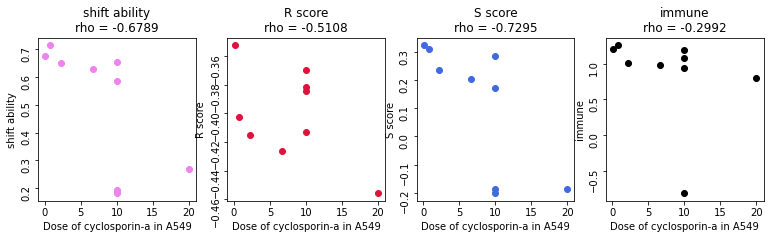



MCF7|parbendazole


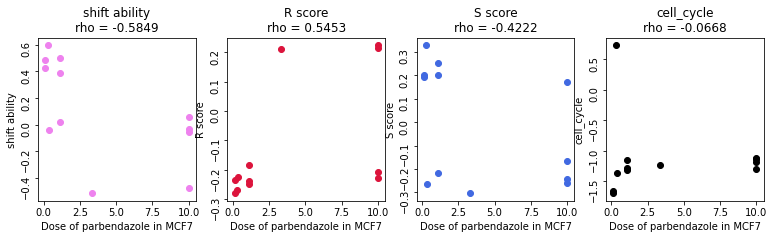

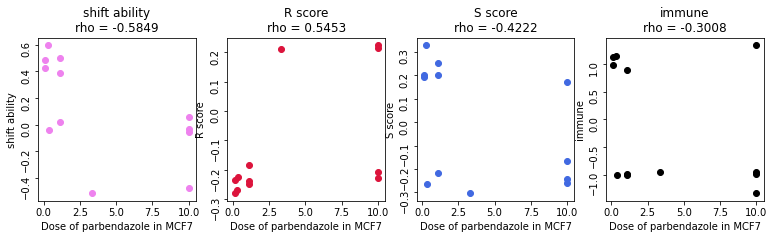



MDAMB231|AZD-7762


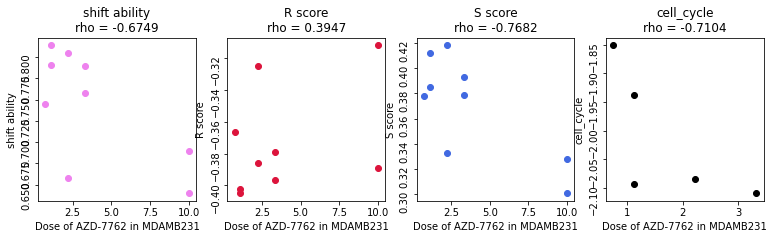

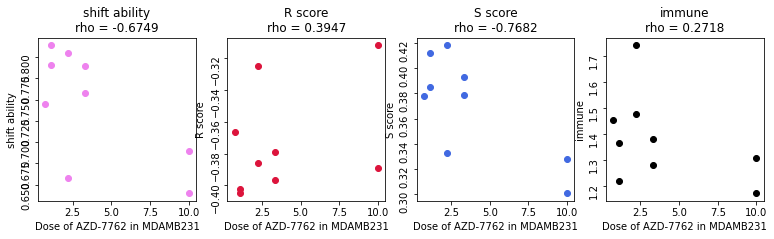



PC3|BIIB-021


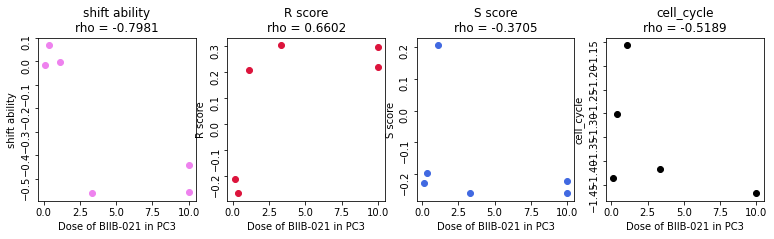

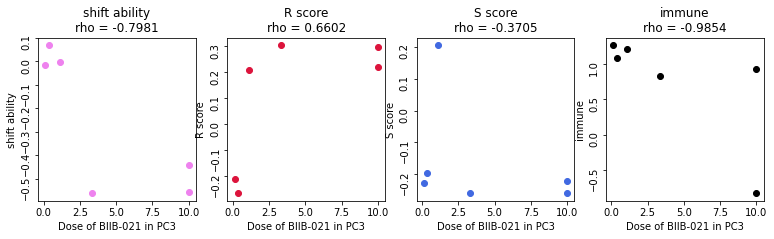



HEPG2|selumetinib


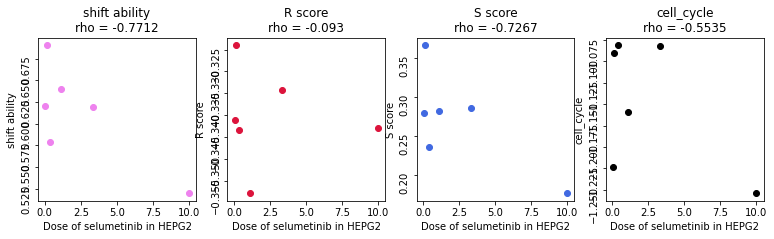

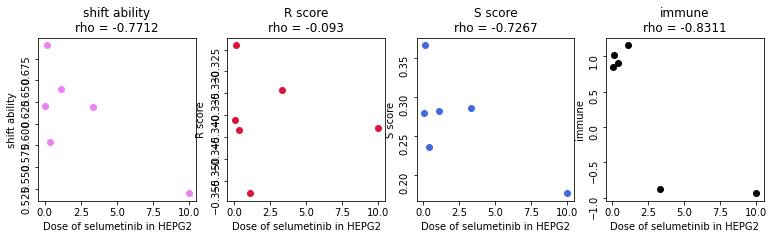



PC3|daunorubicin


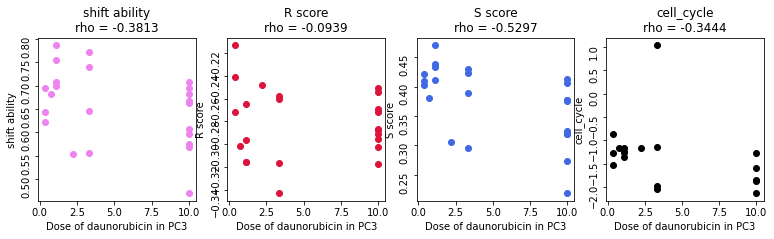

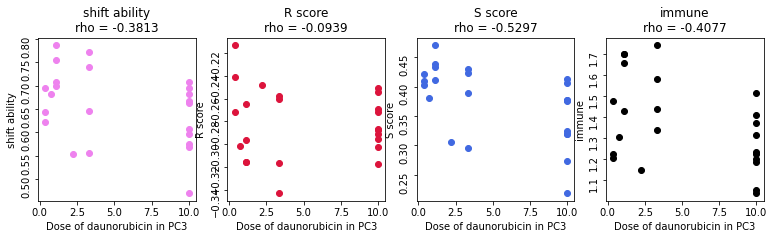



PC3|rotenone


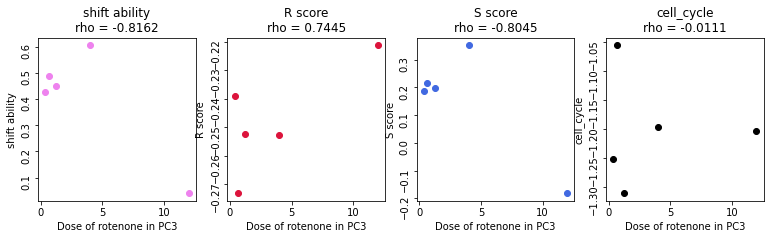

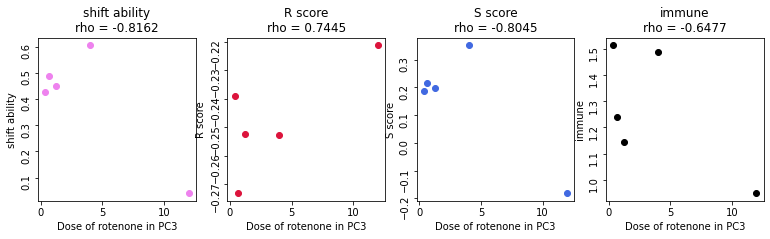



HT29|epirubicin


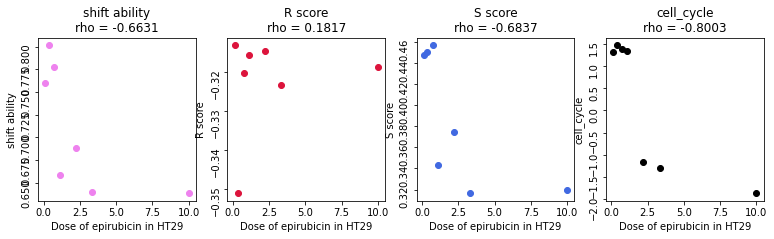

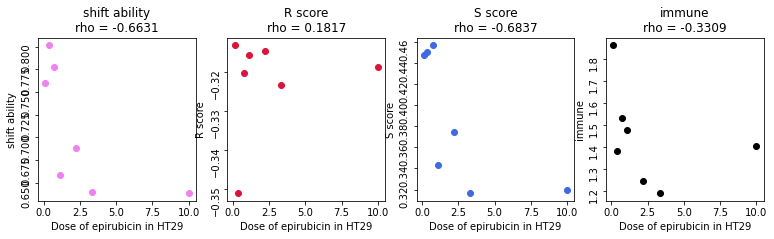

In [266]:
for c in neg_sh_neg_cc_neg_im.index[:20]:
    print(c)
    tmp_c, tmp_d = c.split('|')
    ShcorDoDrug_go(cell_line=tmp_c, 
                   drug_name=tmp_d,
                   go_term='cell_cycle',  
                   go_result=nes_merged,
                   shift_result=all_cp_shift,
                   corr_result=dosage_corr)
    ShcorDoDrug_go(cell_line=tmp_c, 
                   drug_name=tmp_d,
                   go_term='immune',  
                   go_result=nes_merged,
                   shift_result=all_cp_shift,
                   corr_result=dosage_corr)
    print('\n')

In [264]:
# cell death
neg_sh_pos_cd = nes_all_corr_cleaned[nes_all_corr_cleaned['corr_shift'] < 0]
neg_sh_pos_cd = neg_sh_pos_cd[neg_sh_pos_cd['corr_cell_death'] > 0]
neg_sh_pos_cd_neg_im = neg_sh_pos_cd[neg_sh_pos_cd['corr_immune'] < 0]
neg_sh_pos_cd_neg_im = neg_sh_pos_cd_neg_im.sort_values(by='p_shift', ascending=True)

MCF7|tozasertib


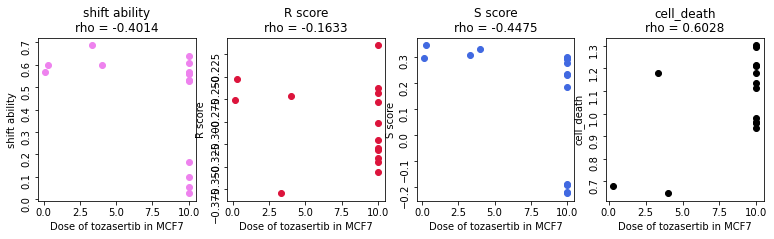

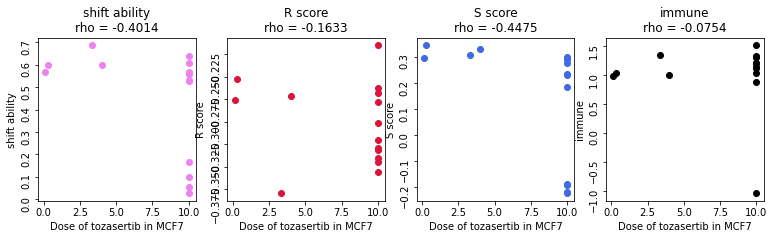



YAPC|clofarabine


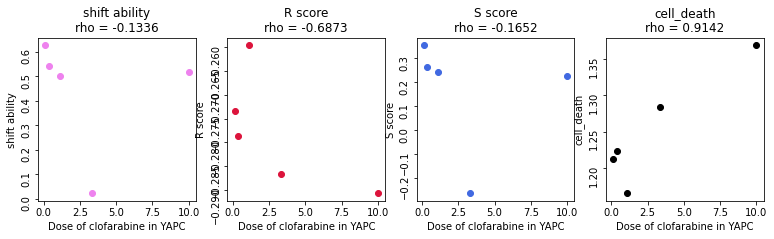

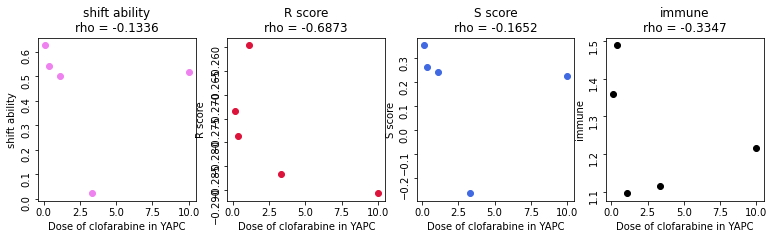



PC3|AZD-7762


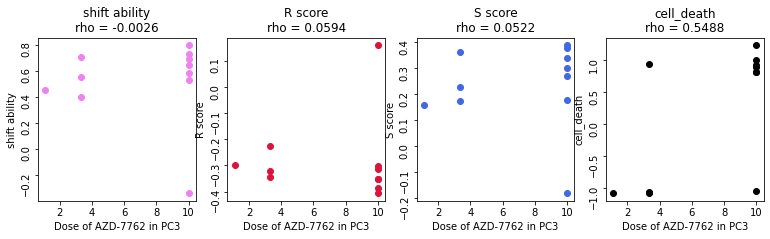

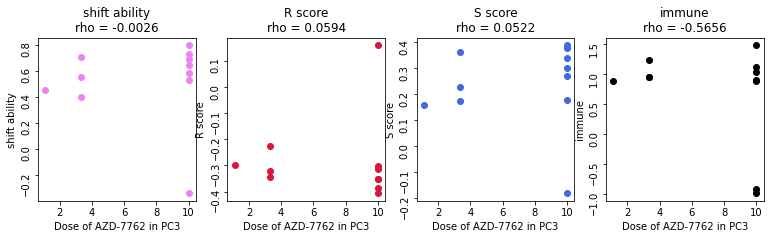



HELA|I-BET-762


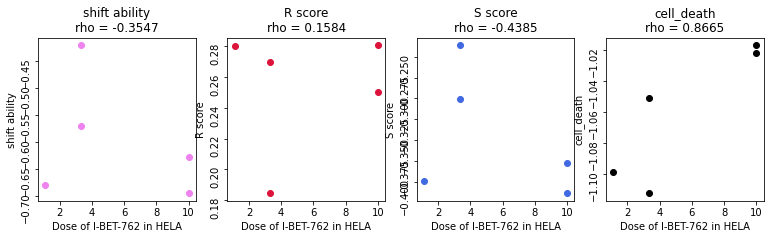

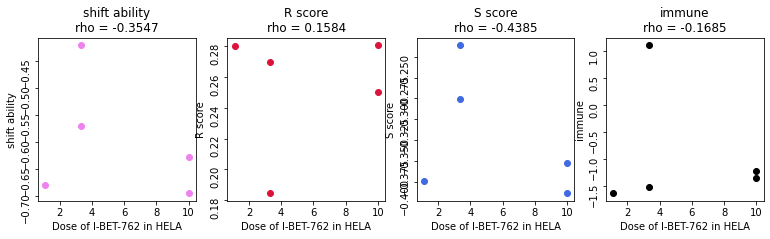



A375|PLX-4720


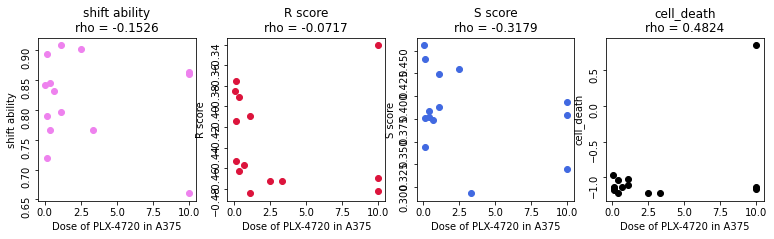

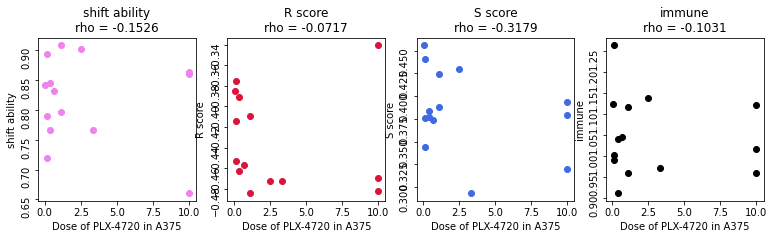



MCF7|tivantinib


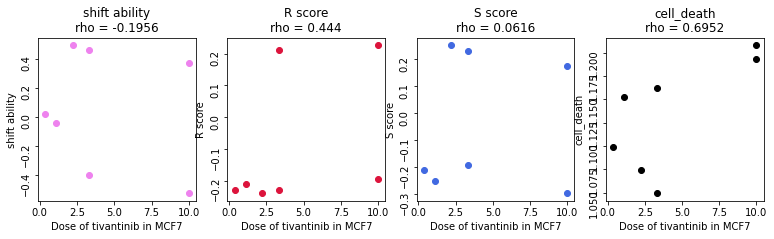

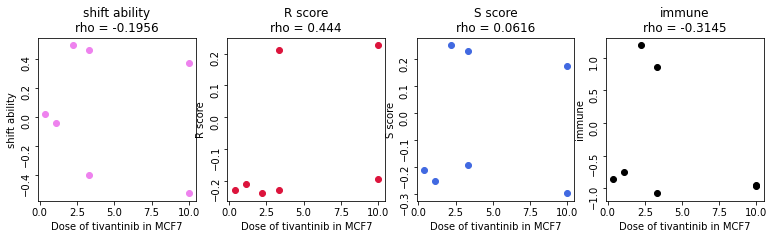



HT29|bortezomib


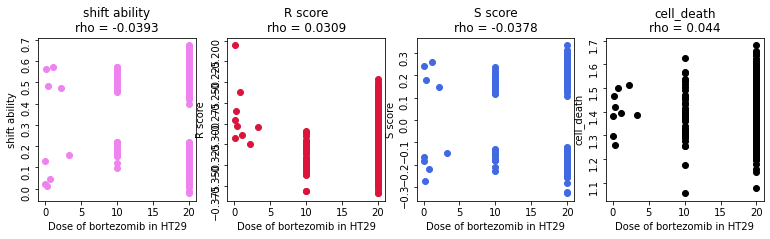

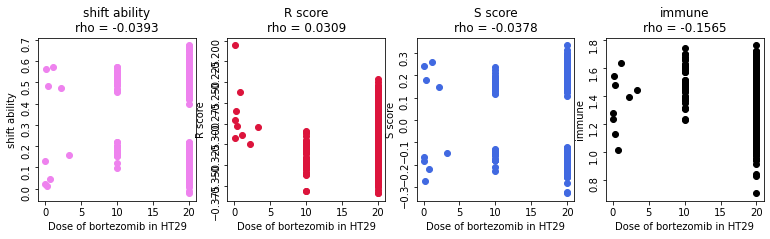



PC3|tivantinib


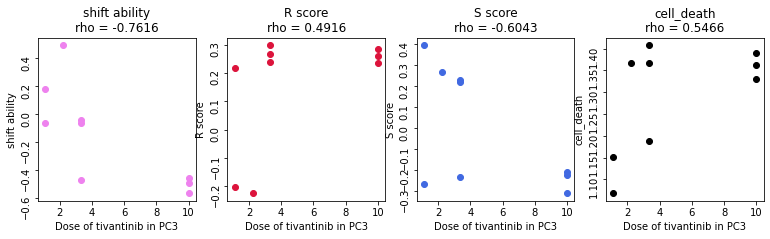

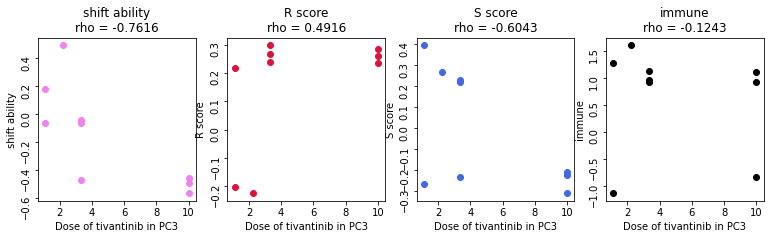



YAPC|PHA-848125


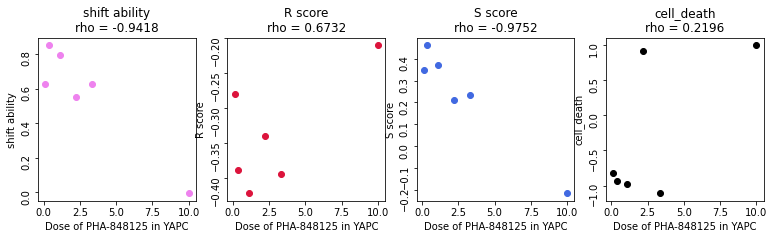

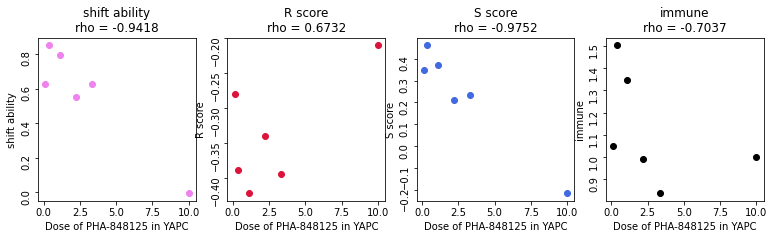



PC3|simvastatin


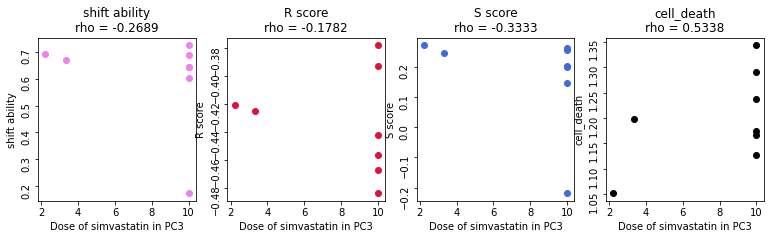

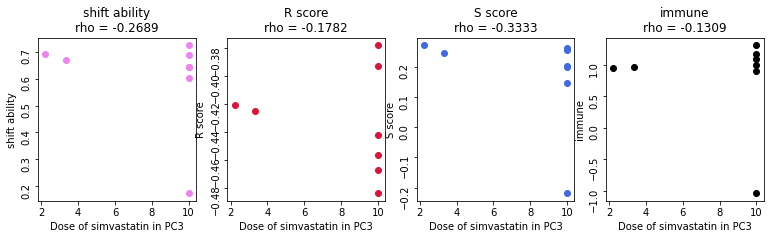



PC3|sunitinib


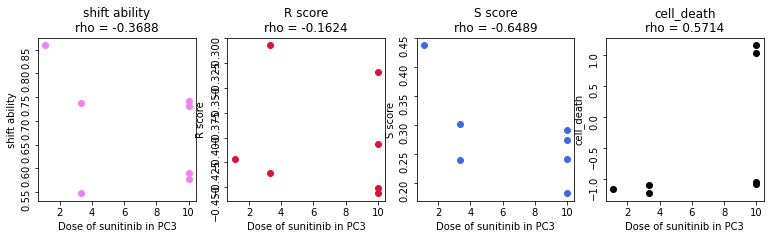

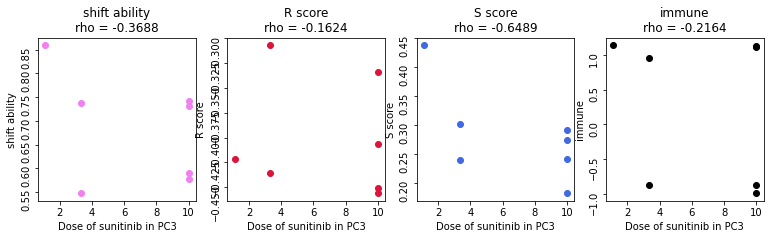



HCC515|gemcitabine


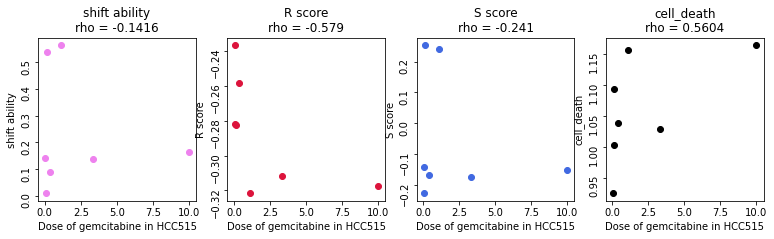

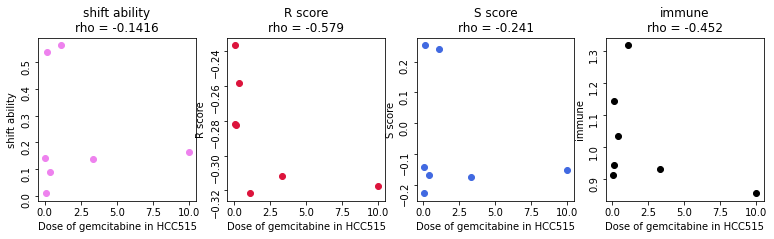



MCF7|torin-2


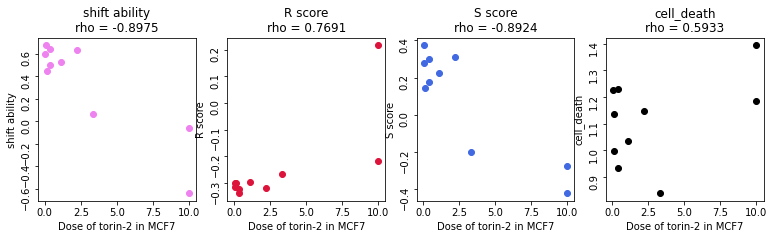

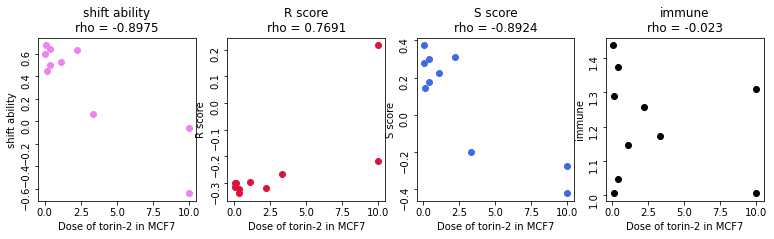



MCF7|rotenone


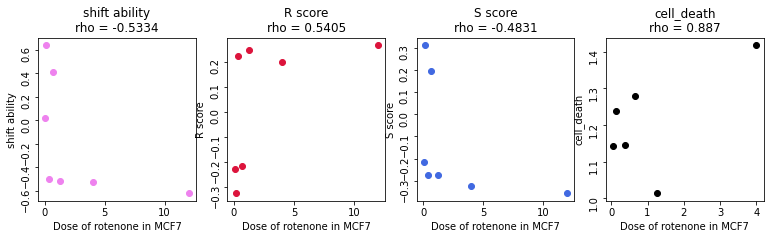

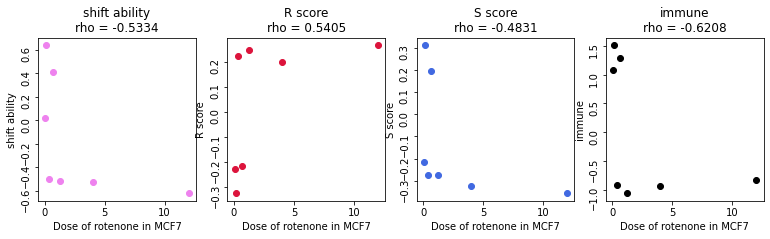



MCF7|bazedoxifene


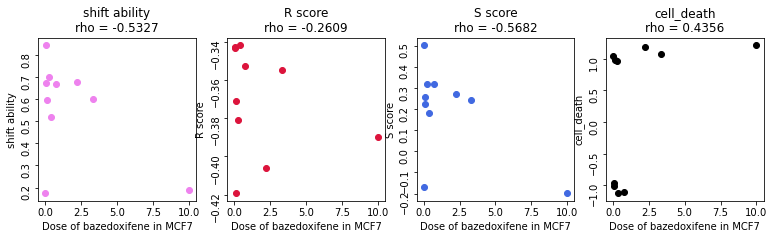

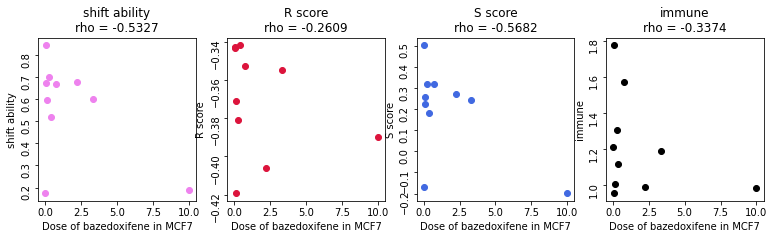



PC3|alectinib


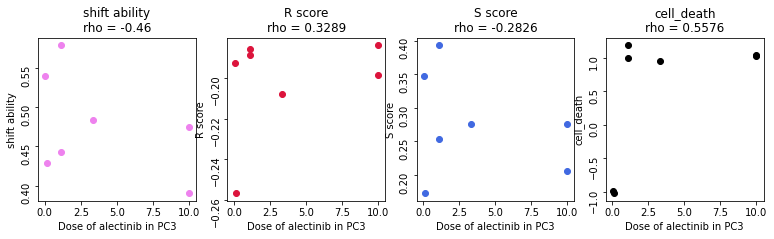

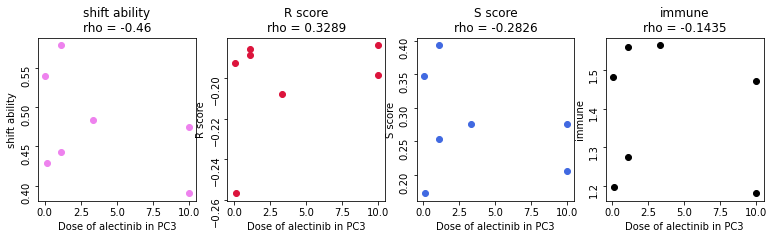



MDAMB231|geldanamycin


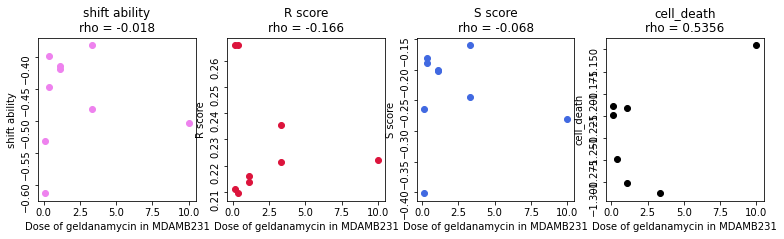

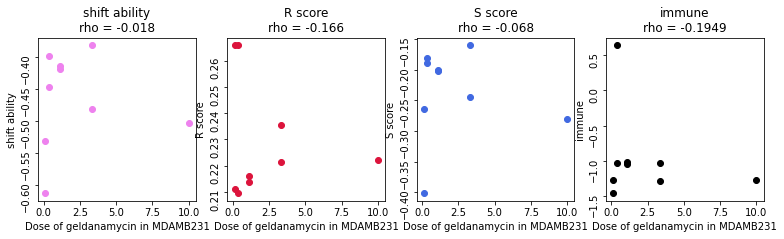



HT29|ixabepilone


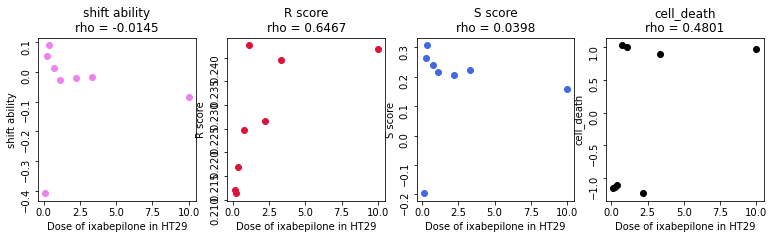

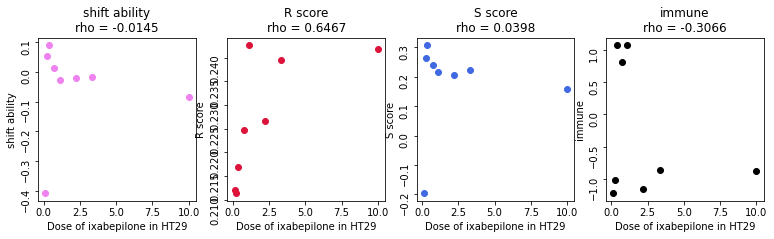



A375|PHA-793887


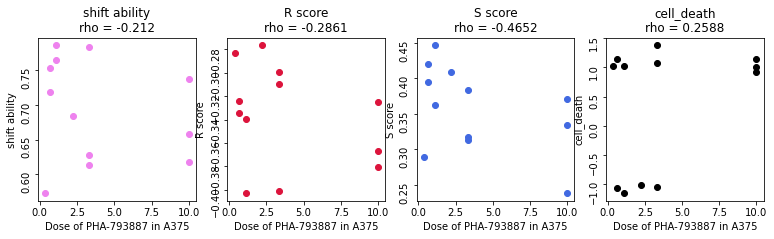

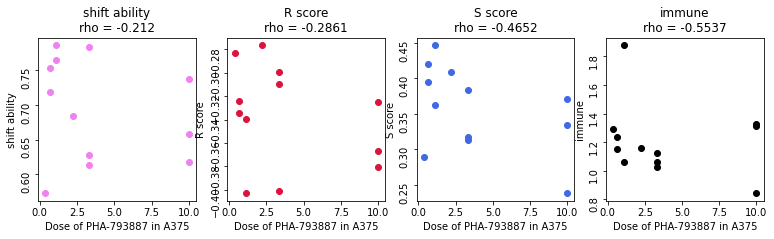



HT29|WYE-125132


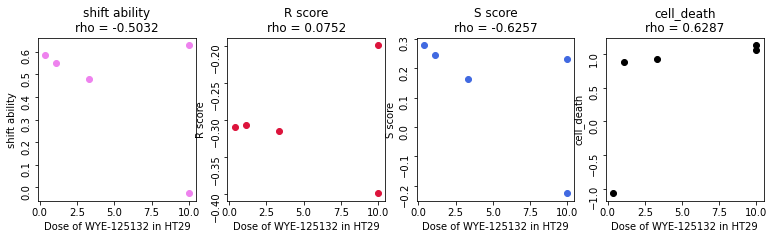

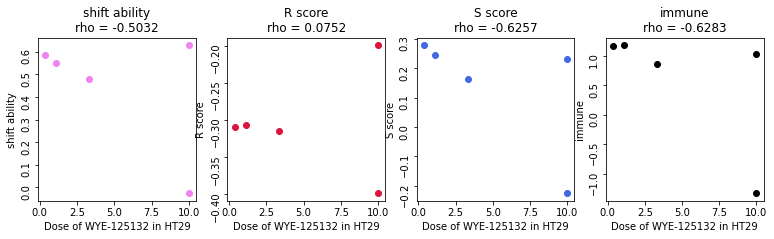

In [327]:
for c in neg_sh_pos_cd_neg_im.sort_values(by='p_cell_death', ascending=True).index[:20]:
    print(c)
    tmp_c, tmp_d = c.split('|')
    ShcorDoDrug_go(cell_line=tmp_c, 
                   drug_name=tmp_d,
                   go_term='cell_death',  
                   go_result=nes_merged,
                   shift_result=all_cp_shift,
                   corr_result=dosage_corr)
    ShcorDoDrug_go(cell_line=tmp_c, 
                   drug_name=tmp_d,
                   go_term='immune',  
                   go_result=nes_merged,
                   shift_result=all_cp_shift,
                   corr_result=dosage_corr)
    print('\n')

In [271]:
# generate GSEA curves for given case
def dose_gsea(cell_line, drug_name, cancer_type, shift_result, go_term_A, go_term_B):
    # initialize
    gsea_result = {}
    
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_sig = tmp_sig[tmp_sig['cell_line'] == cell_line]
    tmp_sig = tmp_sig[tmp_sig['pert_time'] == 24.]
    
    # get the GSEA
    for s in tmp_sig.index:
        p_rename = '__'.join(s.split(':'))
        rnk = pd.read_csv(gsea_home + cancer_type + '/trt_cp/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/GOBP_death_cycle_immune_merged.gmt',
                             processes=20,
                             permutation_num=100,
                             outdir=None, seed=0, min_size=10, max_size=2000)
        
        # save results
        gsea_result[s] = {}
        gsea_result[s][go_term_A] = {} 
        gsea_result[s][go_term_B] = {}

        # save R sig
        gsea_result[s][go_term_A]['hit_indices'] = pre_res.results[go_term_A]['hit_indices']
        tmp_res = []
        for i in pre_res.results[go_term_A]['hit_indices']:
            tmp_res.append(pre_res.results[go_term_A]['RES'][i])
        gsea_result[s][go_term_A]['RES'] = tmp_res

        # save S sig
        gsea_result[s][go_term_B]['hit_indices'] = pre_res.results[go_term_B]['hit_indices']
        tmp_res = []
        for i in pre_res.results[go_term_B]['hit_indices']:
            tmp_res.append(pre_res.results[go_term_B]['RES'][i])
        gsea_result[s][go_term_B]['RES'] = tmp_res
    
    return gsea_result

In [301]:
def visual_gsea(cell_line, drug_name, shift_result,
                gsea_curves, go_term_A, go_term_B,
                color_A, color_B, save_path=None):
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_sig = tmp_sig[tmp_sig['cell_line'] == cell_line]
    tmp_sig = tmp_sig[tmp_sig['pert_time'] == 24.]
    
    
    plt.figure(figsize=(4, 4))
    for s in gsea_curves.keys():
        sns.lineplot(x=gsea_curves[s][go_term_A]['hit_indices'],
                     y=gsea_curves[s][go_term_A]['RES'],
                     color=color_A, alpha=tmp_sig.loc[s, 'nearest_dose'] / 50,
                     linewidth=2 ** tmp_sig.loc[s, 'shift_ability'])
        
        sns.lineplot(x=gsea_curves[s][go_term_B]['hit_indices'],
                     y=gsea_curves[s][go_term_B]['RES'],
                     color=color_B, alpha=tmp_sig.loc[s, 'nearest_dose'] / 50,
                     linewidth=2 ** tmp_sig.loc[s, 'shift_ability'])
    
    plt.title(cell_line + ', ' + drug_name + ', n=' + str(tmp_sig.shape[0]))
    plt.xlim(0, 10174)
    plt.ylim(-.4, .4)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')
    plt.tight_layout()
    fig = plt.gcf()
    if save_path is not None:
        fig.savefig(save_path, transparent=True)
        plt.close()
    else:
        plt.show()
    
    return

In [321]:
def visual_gsea_onlyHL(cell_line, drug_name, shift_result,
                       gsea_curves, go_term_A, go_term_B,
                       color_A, color_B, save_path=None):
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    tmp_sig = tmp_sig[tmp_sig['cell_line'] == cell_line]
    tmp_sig = tmp_sig[tmp_sig['pert_time'] == 24.]
    tmp_low = tmp_sig[tmp_sig['nearest_dose'] == tmp_sig['nearest_dose'].min()]
    tmp_high = tmp_sig[tmp_sig['nearest_dose'] == tmp_sig['nearest_dose'].max()]

    f, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    for s in tmp_low.index:
        sns.lineplot(x=gsea_curves[s][go_term_A]['hit_indices'],
                     y=gsea_curves[s][go_term_A]['RES'], color=color_A,
                     linewidth=2 ** tmp_low.loc[s, 'shift_ability'], ax=axes[0])
        
        sns.lineplot(x=gsea_curves[s][go_term_B]['hit_indices'],
                     y=gsea_curves[s][go_term_B]['RES'], color=color_B,
                     linewidth=2 ** tmp_low.loc[s, 'shift_ability'], ax=axes[0])
    
    for s in tmp_high.index:
        sns.lineplot(x=gsea_curves[s][go_term_A]['hit_indices'],
                     y=gsea_curves[s][go_term_A]['RES'], color=color_A,
                     linewidth=2 ** tmp_high.loc[s, 'shift_ability'], ax=axes[1])
        
        sns.lineplot(x=gsea_curves[s][go_term_B]['hit_indices'],
                     y=gsea_curves[s][go_term_B]['RES'], color=color_B,
                     linewidth=2 ** tmp_high.loc[s, 'shift_ability'], ax=axes[1])
    
    plt.sca(axes[0])
    plt.title(cell_line + ', ' + drug_name + ' at low dosage, n=' + str(tmp_low.shape[0]))
    plt.xlim(0, 10174)
    plt.ylim(-.4, .4)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')

    
    plt.sca(axes[1])
    plt.title(cell_line + ', ' + drug_name + ' at high dosage, n=' + str(tmp_high.shape[0]))
    plt.xlim(0, 10174)
    plt.ylim(-.4, .4)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')
    

    fig = plt.gcf()
    if save_path is not None:
        fig.savefig(save_path, transparent=True)
        plt.close()
    else:
        plt.show()
    
    return

In [276]:
ht29_mtx = dose_gsea(cell_line='HT29',
                     drug_name='mitoxantrone',
                     cancer_type='CRC',
                     shift_result=all_cp_shift,
                     go_term_A='immune', 
                     go_term_B='cell_cycle')

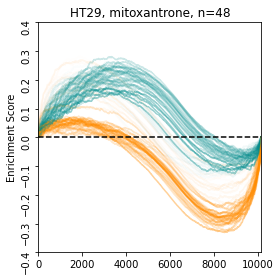

In [306]:
visual_gsea(cell_line='HT29',
            drug_name='mitoxantrone',
            shift_result=all_cp_shift,
            gsea_curves=ht29_mtx,
            go_term_A='immune',
            go_term_B='cell_cycle',
            color_A='darkcyan',
            color_B='darkorange',
            save_path=None)

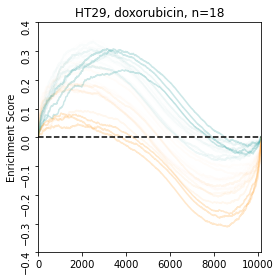

In [307]:
ht29_dox = dose_gsea(cell_line='HT29',
                     drug_name='doxorubicin',
                     cancer_type='CRC',
                     shift_result=all_cp_shift,
                     go_term_A='immune', 
                     go_term_B='cell_cycle')

visual_gsea(cell_line='HT29',
            drug_name='doxorubicin',
            shift_result=all_cp_shift,
            gsea_curves=ht29_dox,
            go_term_A='immune',
            go_term_B='cell_cycle',
            color_A='darkcyan',
            color_B='darkorange',
            save_path=None)

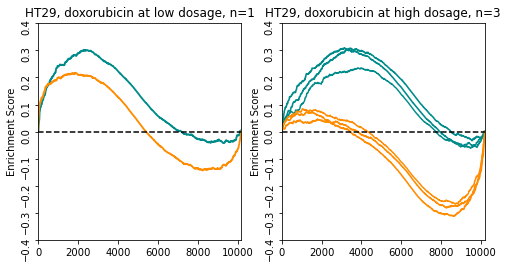

In [322]:
visual_gsea_onlyHL(cell_line='HT29',
                   drug_name='doxorubicin',
                   shift_result=all_cp_shift,
                   gsea_curves=ht29_dox,
                   go_term_A='immune',
                   go_term_B='cell_cycle',
                   color_A='darkcyan',
                   color_B='darkorange',
                   save_path=None)

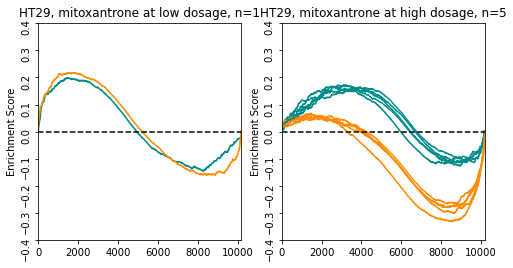

In [323]:
visual_gsea_onlyHL(cell_line='HT29',
                   drug_name='mitoxantrone',
                   shift_result=all_cp_shift,
                   gsea_curves=ht29_mtx,
                   go_term_A='immune',
                   go_term_B='cell_cycle',
                   color_A='darkcyan',
                   color_B='darkorange',
                   save_path=None)

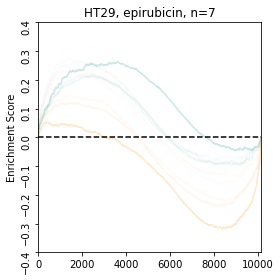

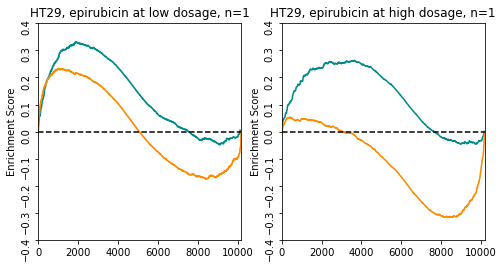

In [324]:
ht29_epi = dose_gsea(cell_line='HT29',
                     drug_name='epirubicin',
                     cancer_type='CRC',
                     shift_result=all_cp_shift,
                     go_term_A='immune', 
                     go_term_B='cell_cycle')

visual_gsea(cell_line='HT29',
            drug_name='epirubicin',
            shift_result=all_cp_shift,
            gsea_curves=ht29_epi,
            go_term_A='immune',
            go_term_B='cell_cycle',
            color_A='darkcyan',
            color_B='darkorange',
            save_path=None)

visual_gsea_onlyHL(cell_line='HT29',
                   drug_name='epirubicin',
                   shift_result=all_cp_shift,
                   gsea_curves=ht29_epi,
                   go_term_A='immune',
                   go_term_B='cell_cycle',
                   color_A='darkcyan',
                   color_B='darkorange',
                   save_path=None)

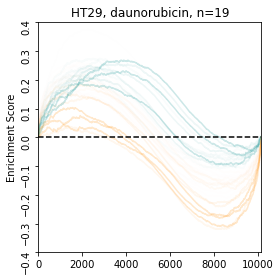

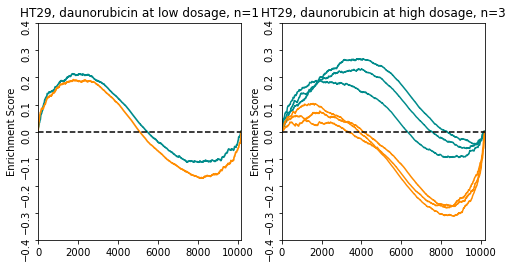

In [325]:
ht29_dau = dose_gsea(cell_line='HT29',
                     drug_name='daunorubicin',
                     cancer_type='CRC',
                     shift_result=all_cp_shift,
                     go_term_A='immune', 
                     go_term_B='cell_cycle')

visual_gsea(cell_line='HT29',
            drug_name='daunorubicin',
            shift_result=all_cp_shift,
            gsea_curves=ht29_dau,
            go_term_A='immune',
            go_term_B='cell_cycle',
            color_A='darkcyan',
            color_B='darkorange',
            save_path=None)

visual_gsea_onlyHL(cell_line='HT29',
                   drug_name='daunorubicin',
                   shift_result=all_cp_shift,
                   gsea_curves=ht29_dau,
                   go_term_A='immune',
                   go_term_B='cell_cycle',
                   color_A='darkcyan',
                   color_B='darkorange',
                   save_path=None)

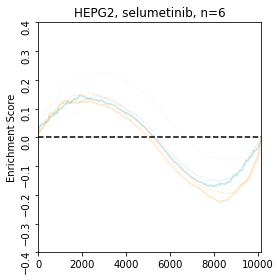

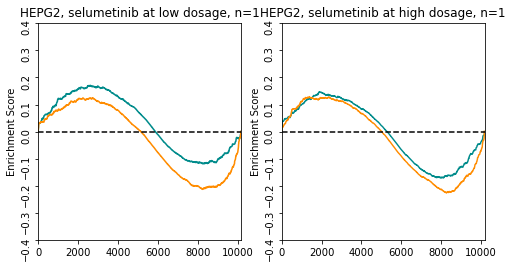

In [326]:
hepg2_sel = dose_gsea(cell_line='HEPG2',
                     drug_name='selumetinib',
                     cancer_type='LIHC',
                     shift_result=all_cp_shift,
                     go_term_A='immune', 
                     go_term_B='cell_cycle')

visual_gsea(cell_line='HEPG2',
            drug_name='selumetinib',
            shift_result=all_cp_shift,
            gsea_curves=hepg2_sel,
            go_term_A='immune',
            go_term_B='cell_cycle',
            color_A='darkcyan',
            color_B='darkorange',
            save_path=None)

visual_gsea_onlyHL(cell_line='HEPG2',
                   drug_name='selumetinib',
                   shift_result=all_cp_shift,
                   gsea_curves=hepg2_sel,
                   go_term_A='immune',
                   go_term_B='cell_cycle',
                   color_A='darkcyan',
                   color_B='darkorange',
                   save_path=None)